# Large Disaster Forecast: Can Census Inform County Level Projections
Questions:
1. Are **Female heads of households**, **households with people with disabilities**, **households with elderly people**, **working individuals** or **SNAP Recipients** good indicators of the number of registrations received by a county in a disaster?
2. Is there a meaningful way to sub-divide the data to reduce the variance?
3. Is there a relationship between the geographic characteristics of a county and the number of registrations received?

> This tool uses open source FEMA and Census data to investigate relationships between family types and size with disaster registrations. The datasets included in this forecast are the Census S2201 Subject Table and two FEMA tables--one for summary information and the other for Individual Assistance Registration counts. 

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile
from datetime import datetime,timedelta
import requests
from io import BytesIO, StringIO
import seaborn as sns


import warnings
warnings.simplefilter(action = 'ignore',category = FutureWarning)
warnings.simplefilter(action = 'ignore',category = RuntimeWarning)
# warnings.simplefilter(action = 'ignore',category = SettingWithCopyWarning)



# Census API Key: Hashed
yourKeyGoesHere = '9d14124eea832221aed405df89e622b1e889aad6'

#NOAA Token
noaaToken = r'JclKoFPahRVySupyHoVYfYLUnZNzawSn'

#Output the last script runtime
scriptBegin = datetime.now()
print(f'The script was last run on {scriptBegin}')
year = scriptBegin.year


The script was last run on 2023-01-10 13:48:48.805058


In [2]:
#Import Machine Learning Libraries: skLearn and StatsModel
from sklearn.preprocessing import StandardScaler
from sklearn.impute import  KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.metrics import  mean_squared_error, r2_score, confusion_matrix, accuracy_score, f1_score, recall_score,precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestRegressor as RFR, RandomForestClassifier as RFC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.cluster import KMeans

import statsmodels.api as sm

In [3]:
#Create a Range of years using Current Year date to enhance repeatability
min_year = 2016
max_year = year
max_census = 2021
# projection_type = 'Severe Storm'

# Functions
1. FEMA API Call
2. Census API Call S2201/DP02
3. Census dataframe conversion
4. Census Datatype conversions

## Function 1: Get FEMA Data from the FEMA API

In [4]:
def get_fema_data(url):
    '''
    Context: The purpose of this function is to generalize the connection to the FEMA API.
             The function accepts the url listed on the website and then adds a json extension.
             The json extension converts the data to a dictionary and then filters the keys for
             the most current data. Not all of the data structures are the same, so if the values
             to reduce the size of the dataset are available, the try and except clause attempts
             to reduce the values looped-in. 
             
    Args:   FEMA url for the api connection
    Output: Dataframe of the FEMA API
    '''
    
    #Convert the url of the data location to the 
    _url = f'{url}.json'
    
    #Use the requests library to get the URL and convert to JSON
    response = requests.get(_url) 
    response_json = response.json()
    
    #Create a loop that accesses the json values
    _data = []
    for key, value in response_json.items():
        #Convert to a dataframe using the DataFrame from dict function
        data = pd.DataFrame.from_dict(value)
        #Filter the Disaster Numbers between 4000 and 5000
        data = data[(data['disasterNumber'].astype(int)>=4000)\
               & (data['disasterNumber'].astype(int)<5000)]
        
        try:
            # Filter data by dropping unnecessary columns
            data = data[data['declarationType']=='DR']
            data = data.drop(['paProgramDeclared','hmProgramDeclared'], axis = 1)
            data = data.drop(['hash','id'], axis = 1)
            data = data.drop(['lastIAFilingDate'], axis = 1)
            data = data.drop(['lastRefresh'], axis = 1)
            data = data.drop(['zipCode','city'], axis = 1)
        except Exception as e:
            pass
        #Append the data to the instantiated variable data
        _data.append(data)
    
    #Convert to a dataframe and reset the index and return the dataframe
    _df = pd.DataFrame(pd.concat(_data, sort = False)).reset_index(drop = True)
    return _df
                       

## Function 2: Census Dataframe Conversion
* Converts the json read in by the api call into a dataframe. 

In [5]:
def json_to_dataframe(response):
    '''
    Convert response variable to dataframe
    '''
    return(pd.DataFrame(response.json()[1:],columns= response.json()[0]))

## Function 3: Generalizable Census API call
* Currently designed to access county level data
* Commented code can be modified using the same inputs to access tract level data

In [6]:
def census_county_detail(year, st_cd, table, elements, yourKeyGoesHere):
    '''
    Context: The purpose of this function is to generalize the connection to the Census api.
             Although Census has libraries this method is more generalizable to all api calls.
             This method calls on all of the county values (see for=county:*), but could be 
             used for Census Tract or Block values. Instantiating this function in a loop
             reduces the likelihood that the user will exceed the 'reasonable' amount of data
             that can be downloaded at any one time.
             
    Args:  
         - year:            This is the year derived from the range of years investigated range(min_year,max_year)
         - st_cd:           The fips state code number derived from the range of 1-72. Census requires a two
                            digit state number listed as a string. This is modified in the loop by adding a zero
                            and converting the value to a string
         - Table:           This is the type of Census table requested. Common Types are Profile and Subject
         - elements:        Census values to be read-in. They can be individual values or entire tables
         - yourKeyGoesHere: Census API Key. Must be requested from Census
                     
    
    Output: List created through the append statement of dataframes from the api call and years called
    '''
    # Creates a path for the requests library to call on the Subject and Group tables
    countyLvlData = f'https://api.census.gov/data/{year}/acs/acs5/{table}?get={elements}&for=county:*&in=state:{st_cd}&key={yourKeyGoesHere}'
    respCountylvl = requests.get(countyLvlData)
    
    try:
        
        #Convert to dataframe and add a year
        data = json_to_dataframe(respCountylvl)
        data['year'] = year 

        #Append the data to the dataframe variable in the loop
        dataframe.append(data)
        
    #Error will print if state numerical code not represented in database (e.g. Alabama = 01, Puerto Rico = 72)
    #This is useful to ensure max tries was not reached and the API call is working appropriately
    except Exception as error:
        raise
        print(year,st_cd,error)

    

## Function 4: Cenus Features and Data Types:
1. Creates a GEOID to create a simple key for later joins
2. Converts numerical values to floating point numbers.
3. Skips important variable character strings

In [7]:
def datatypeconv(dataframe):
    '''
    Context: The purpose of this function is to add a key called GEOID for later joins and
             convert the data types of the numerical census values from objects to floating
             point numbers. 
             
    Args:   Census dataframe created by API call
    Output: Census dataframe created by API call with object types converted to floating point numbers
    '''
    
    #Create a key to make it easier to join the gazateer data
    dataframe['GEOID'] = dataframe['state']+ dataframe['county']
    
   #Convert the data
    for columnName in dataframe.columns:
        try:
            if columnName in  ['state','county','GEOID']:
                pass
            else:
                dataframe[columnName] = dataframe[columnName].astype(float)
        except Exception as e:
            print(e)
        
    return dataframe

In [8]:
def community_impact(s2201_variable):
    '''
    Context: The purpose of this function is to visually inspect the regplots for the subdivided data
             
    Args:   Census element of interest
    Output: Spearman Correlation and Compiled Regplot with the for all the communityImpact levels
    '''
    plt.xlabel(s2201_variable)
    plt.ylabel('totalValidRegistrations')
    for dr_size in dfIncidentType['communityImpact'].unique():
        dfx = dfIncidentType[dfIncidentType['communityImpact'].isin([dr_size])]
        S_corr = dfx[['totalValidRegistrations',f'{s2201_variable}']].corr(method = 'spearman').values[0][1]
        
        #Print the Spearman Correlation. Data is Skewed
        print('{} Community Impact: Spearman Correlation {:.2f}'.format(dr_size,S_corr))
        
        #View the Regplot of the variable to total valid registrations
        sns.regplot(np.log([x+1 for x in dfx[f'{s2201_variable}']])
                   ,np.log([x+1 for x in dfx['totalValidRegistrations']])
                   )

In [9]:
def noaa_water(token, GEOID, incidentBeginDate, incidentDatePlus):
    '''
    Context: This data is generated from an api call to the NOAA Precipitation information. The goal
             Is to find a proxy for the community Impact element. The goal is to reduce subjectivity
             in the Counties projected and the size of the disaster. 
   
    Args:   
          - GEOID:             This is also known as the fips code. First two numbers are the codes 
                               representing each state (AL = 01) and the last three digits are the 
                               county values within each state.     
          - incidentBeginDate: The date of the FEMA Declared Incident
          - incidentDatePlus5: Five Day forecasts are common early in a disaster. This feature creates
                               an end date for the water values to be tallied. 
   
    Output: This function outputs a grouped dataframe with the NOAA data by fips code. 
            The Fips Code and incident begin dates are added for a later join.
    '''
    #url = f'https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=PRCP&limit=1000&units=metric&locationid=FIPS:{GEOID}&startdate={incidentBeginDate}&enddate={incidentDatePlus}'
    url = f'https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&limit=1000&units=metric&locationid=FIPS:{GEOID}&startdate={incidentBeginDate}&enddate={incidentDatePlus}'
#     url = f'https://www.ncei.noaa.gov/cdo-web/api/v2/data&limit=1000&units=metric&locationid=FIPS:{GEOID}&startdate={incidentBeginDate}&enddate={incidentDatePlus}'
    #Assign the token to the requests call
    header = {"token":token}
    response = requests.get(url,headers = header)
    #convert the request call to json
    noaaResponse = response.json()
    
    dataset = []
    #Convert the json to a dictionary and unnest the json
    for key,value in noaaResponse.items():
        for items in value:
            #This is the outer value. must be excluded for a dataframe conversion
            if 'resultset' in items:
                continue
            else:
                #Convert the items iterator to a dataframe and Transpose the data
                data = items
                data = pd.DataFrame.from_dict(data, orient = 'index').T
                #This is called Fips code for context: Key for Join
                data['Fips Code'] = GEOID
                #Assign the incidentBegin date back to the transformed data: Key for Join
                data['incidentBeginDate'] = incidentBeginDate
                dataset.append(data)
    
    #Concatenate the data and then group the dataframe before it is outputted
    dfNoaa = pd.DataFrame(pd.concat(dataset, sort = False))
    #Drop unnessary Columns
    #dfNoaa = dfNoaa.drop(['date','datatype','station','attributes'], axis = 1)
    dfNoaa = dfNoaa.drop(['date','station','attributes'], axis = 1)
    #Converted for later performance
    dfNoaa = dfNoaa.groupby(['Fips Code','incidentBeginDate','datatype']).mean().reset_index()
    #Remove the double leveled index and rename the columns
    #dfNoaa = dfNoaa.reset_index()
    dfNoaa.columns = ['GEOID','incidentBeginDate','datatype','Totals']
    
    #Append the data for a larger dataframe conversion
    #noaa_data.append(dfNoaa)
    return dfNoaa


In [10]:
def usgs_data(state,start_date, end_date):
    '''
    Context: The purpose of this function is to connect to the united States Geological Survey(USGS) API. 
             The hope is that this data will continue to improve the predictability of the communityImact Variable.
             
    Args:   
        -state:
                This argument calls on the state 
            
        -start_date:
                Incident Begin Date
                        
            
        -end_date:
                Incident Begin Date Plus 5 days
            
    Output: Dataframe of the USGS API
    '''
    #StartDate=09/14/2020&EndDate=09/20/2020
    start_date = start_date#.dt.strftime('%m/%d/%Y')
    end_date   = end_date#.dt.strftime('%m/%d/%Y')
    
    url_usgs   = f'https://stn.wim.usgs.gov/STNServices/PeakSummaries/FilteredPeaks.json?State={state}&StartDate={start_date}&EndDate={end_date}'
#     print(url_usgs)
    response   = requests.get(url_usgs)
#     print(response.status_code)
    
    response_json = response.json()
    df_usgs = pd.DataFrame.from_dict(response_json)
    df_usgs['incidentBeginDate'] = start_date 
    return df_usgs


def usgs_state(df_usgs):
    '''
    Context: The purpose of this function is to generalize the connection to the FEMA API.
             The function accepts the url listed on the website and then adds a json extension.
             The json extension converts the data to a dictionary and then filters the keys for
             the most current data. Not all of the data structures are the same, so if the values
             to reduce the size of the dataset are available, the try and except clause attempts
             to reduce the values looped-in. 
             
    Args:   
    Output: 
    '''
    state_usgs = r'https://stn.wim.usgs.gov/STNServices/States.json'
    state_request = requests.get(state_usgs)
    state_request = state_request.json()
    state_request= pd.DataFrame(state_request)
    dataframe_state = pd.merge(df_usgs,state_request
                              ,left_on = 'state'
                              ,right_on = 'state_abbrev'
                              ,how = 'left'
                              )
    return dataframe_state

def usgs_county(df_usgs):
    '''
    Context:  
             
    Args:   
    Output: 
    '''
    county_usgs = r'https://stn.wim.usgs.gov/STNServices/Counties.json'
    county_request = requests.get(county_usgs)
    county_request = county_request.json()
    county_request = pd.DataFrame(county_request)
    df_usgs = pd.merge(df_usgs,county_request
                      , left_on = ['state_id','county']
                      , right_on = ['state_id','county_name']
                      , how = 'left'
                      )
    df_usgs['state_fip']  = df_usgs['state_fip'].astype(str).apply(lambda x: x.zfill(2))
    df_usgs['county_fip'] = df_usgs['county_fip'].astype(str).apply(lambda x: x.zfill(3))
    df_usgs['GEOID'] = df_usgs['state_fip']+df_usgs['county_fip']
    df_usgs['yr'] = pd.to_datetime(df_usgs['incidentBeginDate']).dt.year
    df_usgs['yr'] = df_usgs['yr'].astype(str)
    df_usgs = df_usgs[['yr','GEOID','incidentBeginDate','peak_stage','height_above_gnd']]
    return df_usgs



# 1. Data Gathering: Census Loop
>This loop uses the above function (census_county_detail) to ingest data from the Census API. 

In [11]:
#This is the tables used for the census call
Table = 'subject'
elements = 'group(S2201)'

dataframe = []
#The nested for loop allows for a year parameter to be called 
for year in range(min_year,max_year):
    print(year)
     #This calls on the state codes listed as numerical values
    for st_cd in range(1,73):
        
        try:
            #Range as an int, Census requires a two digit string
            if st_cd in range(1,10):
                st_cd = '0'+str(st_cd)
                #Variables in this function are explained in f(x) above
                census_county_detail(
                                      year=year
                                     ,st_cd = st_cd
                                     ,elements = elements
                                     ,table = Table
                                     ,yourKeyGoesHere=yourKeyGoesHere
                                    )
            
            else:
                st_cd = str(st_cd)
                census_county_detail(
                                      year=year
                                     ,st_cd = st_cd
                                     ,elements = elements
                                     ,table = Table
                                     ,yourKeyGoesHere=yourKeyGoesHere
                                    )

        except Exception as e:
            continue

df_census = pd.DataFrame(pd.concat(dataframe, sort = False))
print('complete')

df_census.tail()

2016
2017
2018
2019
2020
2021
2022
complete


,GEO_ID,NAME,S2201_C01_001E,S2201_C01_001EA,S2201_C01_001M,S2201_C01_001MA,S2201_C01_002E,S2201_C01_002EA,S2201_C01_002M,S2201_C01_002MA,...,S2201_C06_037EA,S2201_C06_037M,S2201_C06_037MA,S2201_C06_038E,S2201_C06_038EA,S2201_C06_038M,S2201_C06_038MA,state,county,year
73,0500000US72145,"Vega Baja Municipio, Puerto Rico",19799,None,451,None,10205,None,344,None,...,None,3.9,None,29.0,None,3.3,None,72,145,2021
74,0500000US72147,"Vieques Municipio, Puerto Rico",2374,None,293,None,1402,None,227,None,...,None,15.7,None,10.1,None,9.6,None,72,147,2021
75,0500000US72149,"Villalba Municipio, Puerto Rico",7823,None,313,None,4000,None,229,None,...,None,7.8,None,33.7,None,7.5,None,72,149,2021
76,0500000US72151,"Yabucoa Municipio, Puerto Rico",11905,None,390,None,6285,None,288,None,...,None,6.0,None,37.0,None,6.7,None,72,151,2021
77,0500000US72153,"Yauco Municipio, Puerto Rico",11836,None,379,None,6961,None,286,None,...,None,5.7,None,28.8,None,5.1,None,72,153,2021


## When Reading in the Data from the Census API:
* MOE and Percentages must be removed
    1. MOE unnecessary for our efforts
    2. Percentages can be created by dividing by Number of Households S2201_C01_001E

In [12]:
#Remove Margin of Error and replace special characters
for column_name in df_census.columns:
    #This reduces performance in the shortrun, but reduces the amount of data managed in the longrun
    if column_name[-1]=='M' or column_name[-2:]=='MA'\
    or column_name[-2:]=='EA' or column_name[-2:]=='PE':
        df_census.drop(column_name, axis = 1, inplace = True)
        print(column_name, 'MOE/Annotation Removed')
        
    #Percentages are removed:
    #Percentages can be created by dividing by the number of households ['S2201_C01_001E']
    elif 'C02' in column_name[6:9] or 'C04'in column_name[6:9] or 'C06' in column_name[6:9]:
        df_census.drop(column_name, axis = 1, inplace = True)
        print(column_name, 'Percentages Removed')
print('complete')        

S2201_C01_001EA MOE/Annotation Removed
S2201_C01_001M MOE/Annotation Removed
S2201_C01_001MA MOE/Annotation Removed
S2201_C01_002EA MOE/Annotation Removed
S2201_C01_002M MOE/Annotation Removed
S2201_C01_002MA MOE/Annotation Removed
S2201_C01_003EA MOE/Annotation Removed
S2201_C01_003M MOE/Annotation Removed
S2201_C01_003MA MOE/Annotation Removed
S2201_C01_004EA MOE/Annotation Removed
S2201_C01_004M MOE/Annotation Removed
S2201_C01_004MA MOE/Annotation Removed
S2201_C01_005EA MOE/Annotation Removed
S2201_C01_005M MOE/Annotation Removed
S2201_C01_005MA MOE/Annotation Removed
S2201_C01_006EA MOE/Annotation Removed
S2201_C01_006M MOE/Annotation Removed
S2201_C01_006MA MOE/Annotation Removed
S2201_C01_007EA MOE/Annotation Removed
S2201_C01_007M MOE/Annotation Removed
S2201_C01_007MA MOE/Annotation Removed
S2201_C01_008EA MOE/Annotation Removed
S2201_C01_008M MOE/Annotation Removed
S2201_C01_008MA MOE/Annotation Removed
S2201_C01_009EA MOE/Annotation Removed
S2201_C01_009M MOE/Annotation Rem

In [13]:
#Make a copy of the df_census Dataframe and reset the index
dfCensus = df_census.copy()
dfCensus.reset_index(drop = True, inplace = True)

#Convert the datatypes
#Data is read in as an object. This function converts all numerical values
dfcensus = datatypeconv(dfCensus)

dfcensus.head()

could not convert string to float: '0500000US01099'
could not convert string to float: 'Monroe County, Alabama'


,GEO_ID,NAME,S2201_C01_001E,S2201_C01_002E,S2201_C01_003E,S2201_C01_004E,S2201_C01_005E,S2201_C01_006E,S2201_C01_007E,S2201_C01_008E,...,S2201_C05_033E,S2201_C05_034E,S2201_C05_035E,S2201_C05_036E,S2201_C05_037E,S2201_C05_038E,state,county,year,GEOID
0,0500000US01099,"Monroe County, Alabama",8316.0,3447.0,4869.0,3655.0,1502.0,422.0,1080.0,3159.0,...,4341.0,34347.0,4300.0,1324.0,1478.0,1498.0,01,099,2016.0,01099
1,0500000US01079,"Lawrence County, Alabama",13321.0,5198.0,8123.0,7230.0,2226.0,670.0,1556.0,3865.0,...,8656.0,50079.0,7868.0,1489.0,3045.0,3334.0,01,079,2016.0,01079
2,0500000US01081,"Lee County, Alabama",57901.0,16256.0,41645.0,25640.0,10678.0,2430.0,8248.0,21583.0,...,37249.0,50247.0,31115.0,4028.0,9593.0,17494.0,01,081,2016.0,01081
3,0500000US01093,"Marion County, Alabama",12486.0,5577.0,6909.0,6802.0,2130.0,509.0,1621.0,3554.0,...,9701.0,40586.0,7431.0,1542.0,2268.0,3621.0,01,093,2016.0,01093
4,0500000US01107,"Pickens County, Alabama",7618.0,3305.0,4313.0,3317.0,1483.0,411.0,1072.0,2818.0,...,4007.0,39128.0,3923.0,891.0,1174.0,1858.0,01,107,2016.0,01107


In [14]:
print('Number of Census columns in the dataset: ',len(dfCensus.columns))

Number of Census columns in the dataset:  120


In [15]:
#This dataset has 120 columns after intial cleaning complete. Use while loop to look at datatypes and nulls 
n = 0
i = 15
while i <= len(dfCensus.columns):
    print(i)
    dfcensus.iloc[:,n:i].info()
    n+=15
    i+=15

15
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19322 entries, 0 to 19321
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   GEO_ID          19322 non-null  object 
 1   NAME            19322 non-null  object 
 2   S2201_C01_001E  19322 non-null  float64
 3   S2201_C01_002E  19322 non-null  float64
 4   S2201_C01_003E  19322 non-null  float64
 5   S2201_C01_004E  19322 non-null  float64
 6   S2201_C01_005E  19322 non-null  float64
 7   S2201_C01_006E  19322 non-null  float64
 8   S2201_C01_007E  19322 non-null  float64
 9   S2201_C01_008E  19322 non-null  float64
 10  S2201_C01_009E  19322 non-null  float64
 11  S2201_C01_010E  19322 non-null  float64
 12  S2201_C01_011E  19322 non-null  float64
 13  S2201_C01_012E  19322 non-null  float64
 14  S2201_C01_013E  19322 non-null  float64
dtypes: float64(13), object(2)
memory usage: 2.2+ MB
30
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19322 entries, 0 

## This is Additional Metadata from Census
* Area Square Miles
* Water Square Miles
* County information 


In [16]:
# https://www2.census.gov/geo/docs/maps-data/data/gazetteer/2022_Gazetteer/2022_Gaz_counties_national.zip #
gazetteer = []

#This loop accesses the many years of Census Gazetteer data for a join. 
 #It contains information about the geographic characteristics of the counties
for yr in range(min_year,max_year):
    try:
    #Read in each year's worth of data
        g_url = f'https://www2.census.gov/geo/docs/maps-data/data/gazetteer/{yr}_Gazetteer/{yr}_Gaz_counties_national.zip'
        #Use requests library to mke call
        resp = requests.get(g_url)
        #print(resp.status_code)
        #print(g_url)
        #Convert the Zipfile call to Bytes
        zipfile = ZipFile(BytesIO(resp.content))
        #Unnest the Zip file and read in the data
        for file in zipfile.namelist():
            data = pd.read_csv(zipfile.open(file,'r'), sep = '\t'
                               ,encoding_errors= 'replace'
                               ,dtype = {'GEOID':str}
                              )
            data['year'] = str(yr)
            data['st_cd'] = data['GEOID'].str.slice(start = 0, stop = 2)
            data['Fips_county'] = data['GEOID'].str.slice(start  = 2, stop = 6 )
            gazetteer.append(data)
    except Exception as e:
        print(resp.status_code,g_url,e)
                
df_gaz = pd.DataFrame(pd.concat(gazetteer,sort = False))
df_gaz.head()

,USPS,GEOID,ANSICODE,NAME,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG,year,st_cd,Fips_county
0,AL,01001,161526,Autauga County,1539609015,25749942,594.446,9.942,32.532237,-86.646440,2016,01,001
1,AL,01003,161527,Baldwin County,4117584019,1133130502,1589.808,437.504,30.659218,-87.746067,2016,01,003
2,AL,01005,161528,Barbour County,2291818680,50864677,884.876,19.639,31.870253,-85.405104,2016,01,005
3,AL,01007,161529,Bibb County,1612481559,9287974,622.583,3.586,33.015893,-87.127148,2016,01,007
4,AL,01009,161530,Blount County,1670041875,15077458,644.807,5.821,33.977358,-86.566440,2016,01,009


In [17]:
# Rename the columns
df_gaz.columns = ['USPS','GEOID','ANSICODE','NAME'
                  ,'ALAND','AWATER','ALAND_SQMI'
                  ,'AWATER_SQMI','INTPTLAT','INTPTLONG','year'
                  ,'st_cd','Fips_county'
                 ]


## 1. Data Gathering: FEMA DATA

In [18]:
#Call on the Summary table from the API
summary_url = r'https://www.fema.gov/api/open/v2/DisasterDeclarationsSummaries'
summary_df = get_fema_data(summary_url)

#Call on the Summary table from the API
url4 = r'https://www.fema.gov/api/open/v2/RegistrationIntakeIndividualsHouseholdPrograms'
fema_df = get_fema_data(url4)

#Group the data by disaster, state and county to aggregate the values in the dataframe
fema_df = fema_df.groupby(['disasterNumber','state','county']).sum()

#Reset the index to eliminate the multi-index
#Drop set to false to keep the indexed columns
fema_df = fema_df.reset_index()

#Join the Summary and county datasets
df_fema = pd.merge(fema_df,summary_df
                   ,left_on = ['disasterNumber','state','county']
                   ,right_on = ['disasterNumber','state','designatedArea']
                   ,how = 'left'
                   ,suffixes = ['_summary','_county'] 
                  )
#Assign the year for a futue join. 
df_fema['declarationDate'] = pd.to_datetime(df_fema['declarationDate'])
df_fema['yr'] = df_fema['declarationDate'].dt.year
df_fema['year'] = df_fema['yr'].astype(str).str.replace('2022.0','2021.0')

#Filter the Number of years from 2016 forward
df_fema = df_fema[df_fema['yr']>=min_year
                 ].reset_index(drop=True)
# df_fema = df_fema[df_fema['totalValidRegistrations']>10].reset_index(drop = True)
#Inspect the data
df_fema.tail()

,disasterNumber,state,county,totalValidRegistrations,validCallCenterRegistrations,validWebRegistrations,validMobileRegistrations,ihpReferrals,ihpEligible,ihpAmount,...,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,yr,year
4719,4680,FL,Flagler (County),309,97,98,114,223,59,252445.29,...,2022-11-07T00:00:00.000Z,2022-11-30T00:00:00.000Z,None,12,035,99035,Flagler (County),22104,2022.0,2021.0
4720,4680,FL,Lake (County),225,40,65,120,114,10,37125.90,...,2022-11-07T00:00:00.000Z,2022-11-30T00:00:00.000Z,None,12,069,99069,Lake (County),22104,2022.0,2021.0
4721,4680,FL,Putnam (County),172,29,33,110,92,26,78795.72,...,2022-11-07T00:00:00.000Z,2022-11-30T00:00:00.000Z,None,12,107,99107,Putnam (County),22104,2022.0,2021.0
4722,4680,FL,St. Johns (County),130,29,44,57,84,20,64963.59,...,2022-11-07T00:00:00.000Z,2022-11-30T00:00:00.000Z,None,12,109,99109,St. Johns (County),22104,2022.0,2021.0
4723,4680,FL,Volusia (County),1904,373,547,984,1244,236,1113387.17,...,2022-11-07T00:00:00.000Z,2022-11-30T00:00:00.000Z,None,12,127,99127,Volusia (County),22104,2022.0,2021.0


# 2. Data Understanding

<AxesSubplot:>

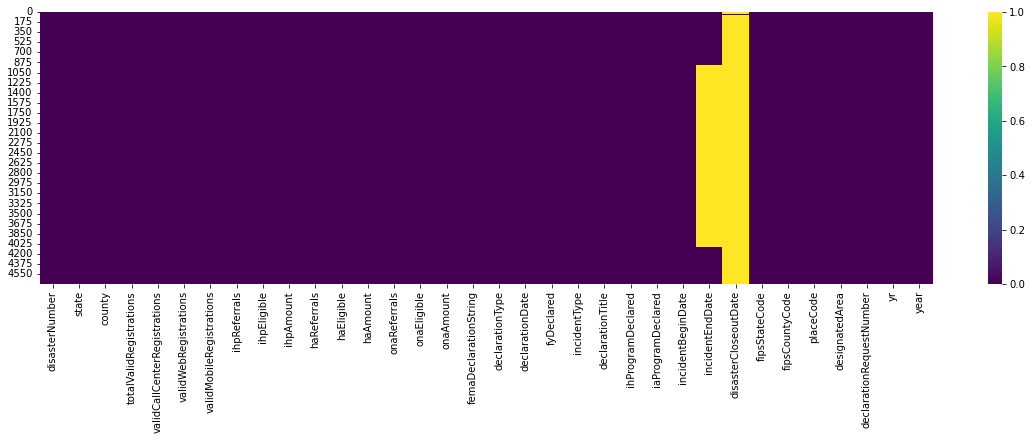

In [19]:
# Use the heatmap to see if there are columns to drop
plt.figure(figsize = [20,5])
sns.heatmap(df_fema.isnull(),cmap = 'viridis')

In [20]:

#Convert the year to a string for merging later
df_fema.year = df_fema.year.astype(float).astype(int).astype(str)

#Drop mostly null elements
df_fema.drop(['incidentEndDate','disasterCloseoutDate'], axis = 1, inplace = True)

#Convert Declaration Date to a datetime type and add a year column to join in the next step
df_fema['incidentBeginDate'] = pd.to_datetime(df_fema['incidentBeginDate'])
df_fema['Number of Days'] = df_fema['declarationDate'] - df_fema['incidentBeginDate']

#Assign the number of days for future modeling
df_fema['Number of Days'] = df_fema['Number of Days'].dt.days 

#Investigate additional Null values
df_fema.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4724 entries, 0 to 4723
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype              
---  ------                        --------------  -----              
 0   disasterNumber                4724 non-null   int64              
 1   state                         4724 non-null   object             
 2   county                        4724 non-null   object             
 3   totalValidRegistrations       4724 non-null   int64              
 4   validCallCenterRegistrations  4724 non-null   int64              
 5   validWebRegistrations         4724 non-null   int64              
 6   validMobileRegistrations      4724 non-null   int64              
 7   ihpReferrals                  4724 non-null   int64              
 8   ihpEligible                   4724 non-null   int64              
 9   ihpAmount                     4724 non-null   float64            
 10  haReferrals                   4724 n

In [21]:
df_fema.disasterNumber.nunique()


180

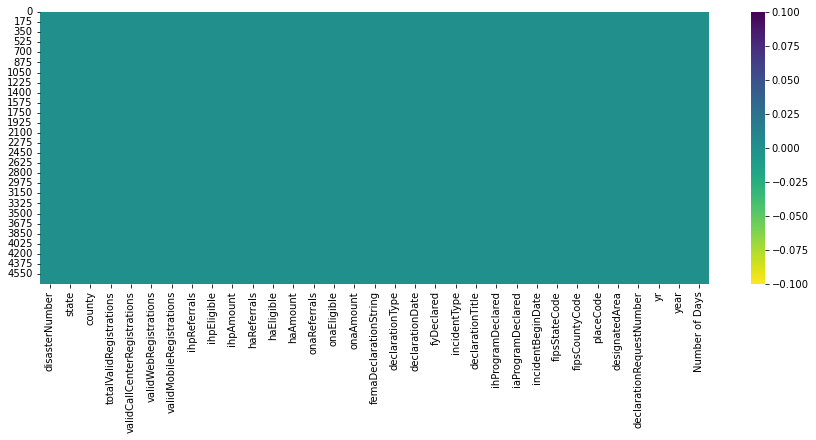

In [22]:
#Visually inspect the nulls
plt.figure(figsize = [15,5])
sns.heatmap(df_fema.isnull(), cmap = 'viridis_r');

In [23]:
#Create a GEOID column to make joining easier in th next step
df_fema['GEOID'] = df_fema['fipsStateCode'] + df_fema['fipsCountyCode'] 

df_fema.reset_index(inplace = True, drop = True)

In [24]:
df_gaz['yr'] = df_gaz['year'].astype(str)
df_fema['yr'] = df_fema['yr'].astype(str).str.split('.',expand = True)[0]
df_gaz.drop('year', axis = 1, inplace = True)

In [25]:
#Join the FEMA data and the gazateer Data
df_fema = pd.merge(df_fema,df_gaz 
                  ,on       = ['GEOID','yr']  
                  ,how      = 'left'
                  ,suffixes = ['_S','_G']
                  )
df_fema.head()

,disasterNumber,state,county,totalValidRegistrations,validCallCenterRegistrations,validWebRegistrations,validMobileRegistrations,ihpReferrals,ihpEligible,ihpAmount,...,ANSICODE,NAME,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG,st_cd,Fips_county
0,4248,MS,Benton (County),159,124,30,5,134,44,443296.26,...,695729.0,Benton County,1.053131e+09,5279183.0,406.616,2.038,34.810518,-89.200285,28,009
1,4248,MS,Coahoma (County),271,178,73,20,241,57,296059.98,...,695738.0,Coahoma County,1.431035e+09,79322563.0,552.526,30.627,34.228670,-90.603165,28,027
2,4248,MS,Marshall (County),378,264,77,37,326,101,1067090.66,...,695770.0,Marshall County,1.828990e+09,9195190.0,706.177,3.550,34.766190,-89.504231,28,093
3,4248,MS,Monroe (County),89,70,18,1,83,46,307400.29,...,695771.0,Monroe County,1.981581e+09,18138022.0,765.093,7.003,33.890030,-88.485038,28,095
4,4248,MS,Panola (County),46,35,6,5,39,10,30547.65,...,695776.0,Panola County,1.774512e+09,51769784.0,685.143,19.988,34.365205,-89.963065,28,107


# Prepare Data for NOAA Data Join later

In [26]:
#Three day forecast to get values for all disasters without reaching 10K limit imposed by NOAA
df_fema['incidentdatePlus3'] = pd.to_datetime(df_fema['incidentBeginDate'])+timedelta(days=3)
df_fema['incidentdatePlus3'] = df_fema['incidentdatePlus3'].dt.strftime('%Y-%m-%d')

#Five day forecasts are common early in a disaster. So Five day totals are aggregated in the model
df_fema['incidentdatePlus5'] = pd.to_datetime(df_fema['incidentBeginDate'])+timedelta(days=5)
df_fema['incidentdatePlus5'] = df_fema['incidentdatePlus5'].dt.strftime('%Y-%m-%d')

#Convert incidentBeginDate to datetime 
df_fema['incidentBeginDate'] = pd.to_datetime(df_fema['incidentBeginDate']).dt.strftime('%Y-%m-%d')
df_fema.head(50)

,disasterNumber,state,county,totalValidRegistrations,validCallCenterRegistrations,validWebRegistrations,validMobileRegistrations,ihpReferrals,ihpEligible,ihpAmount,...,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG,st_cd,Fips_county,incidentdatePlus3,incidentdatePlus5
0,4248,MS,Benton (County),159,124,30,5,134,44,443296.26,...,1.053131e+09,5279183.0,406.616,2.038,34.810518,-89.200285,28,009,2015-12-26,2015-12-28
1,4248,MS,Coahoma (County),271,178,73,20,241,57,296059.98,...,1.431035e+09,79322563.0,552.526,30.627,34.228670,-90.603165,28,027,2015-12-26,2015-12-28
2,4248,MS,Marshall (County),378,264,77,37,326,101,1067090.66,...,1.828990e+09,9195190.0,706.177,3.550,34.766190,-89.504231,28,093,2015-12-26,2015-12-28
3,4248,MS,Monroe (County),89,70,18,1,83,46,307400.29,...,1.981581e+09,18138022.0,765.093,7.003,33.890030,-88.485038,28,095,2015-12-26,2015-12-28
4,4248,MS,Panola (County),46,35,6,5,39,10,30547.65,...,1.774512e+09,51769784.0,685.143,19.988,34.365205,-89.963065,28,107,2015-12-26,2015-12-28
5,4248,MS,Prentiss (County),11,9,2,0,11,2,26272.97,...,1.074778e+09,8353594.0,414.974,3.225,34.621104,-88.522179,28,117,2015-12-26,2015-12-28
6,4248,MS,Quitman (County),197,155,28,14,176,37,323572.88,...,1.048976e+09,3676001.0,405.012,1.419,34.252833,-90.290171,28,119,2015-12-26,2015-12-28
7,4248,MS,Tippah (County),101,82,14,5,90,31,409659.04,...,1.185726e+09,5551259.0,457.811,2.143,34.763618,-88.918819,28,139,2015-12-26,2015-12-28
8,4250,MO,Barry (County),82,57,21,4,63,35,111853.73,...,2.015659e+09,32942044.0,778.250,12.719,36.699378,-93.834326,29,009,2015-12-26,2015-12-28
9,4250,MO,Barton (County),14,12,1,1,12,2,2605.54,...,1.533068e+09,12434943.0,591.921,4.801,37.500799,-94.344089,29,011,2015-12-26,2015-12-28


# Dropping Null Vaues:
> In some instances, FEMA works with units of government that do not have corresponding Census Values. Therefore, the values for these units of government were dropped.

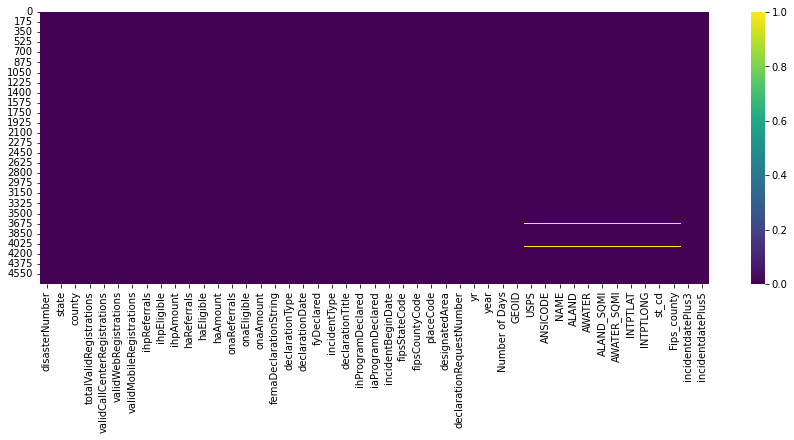

In [27]:
#Visually inspect the nulls
plt.figure(figsize = [15,5])
sns.heatmap(df_fema.isnull(), cmap = 'viridis');

In [28]:
#Convert year to a string and rename the year column for a later join
df_fema.yr = df_fema.yr.astype(str)
df_fema.rename(columns = {'year_S':'year'}, inplace = True)

# Subdivide conus and oconus
df_oConus = df_fema[df_fema['Fips_county'].isnull()].reset_index(drop = True)
df_fema = df_fema[~df_fema['Fips_county'].isnull()].reset_index(drop = True)


'''
df_oConus is a mix of island territories (excluding Puerto Rico) and First Nations. 
They Include:
   'St. John (Island) (County-equivalent)',
   'St. Thomas (Island) (County-equivalent)',
   'St. Croix (Island) (County-equivalent)',
   'Big Cypress Indian Reservation', 'Brighton Indian Reservation',
   'Fort Pierce Indian Reservation', 'Hollywood Indian Reservation',
   'Immokalee Indian Reservation', 'Tampa Reservation',
   'Eastern (District)', "Manu'a (District)",
   'Rose Island (Island) (County-equivalent)',
   'Swains Island (Island) (County-equivalent)', 'Western (District)',
   'Rota (Municipality)', 'Saipan (Municipality)',
   'Tinian (Municipality)', 'Santee Indian Reservation',
   'Oglala Lakota (County)', 'Guam (County-equivalent)',
   'Northern Mariana Islands (County-equivalent)', 'Bedford',
   'Mississippi Choctaw Indian Reservation',
   'Valdez-Cordova (Census Area)', 'Wade Hampton (Census Area)',
   'Mashantucket Pequot Indian Reservation', 'Mohegan Trust Lands',
   'Lummi Indian Reservation', 'Nooksack Indian Reservation',
   'Quileute Indian Reservation',
   'Salt River Pima-Maricopa Indian Community',
   'Kashunamiut Regional Educational Attendance Area',
   'Seminole Indian Trust Lands'
'''

df_fema.head()

,disasterNumber,state,county,totalValidRegistrations,validCallCenterRegistrations,validWebRegistrations,validMobileRegistrations,ihpReferrals,ihpEligible,ihpAmount,...,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG,st_cd,Fips_county,incidentdatePlus3,incidentdatePlus5
0,4248,MS,Benton (County),159,124,30,5,134,44,443296.26,...,1.053131e+09,5279183.0,406.616,2.038,34.810518,-89.200285,28,009,2015-12-26,2015-12-28
1,4248,MS,Coahoma (County),271,178,73,20,241,57,296059.98,...,1.431035e+09,79322563.0,552.526,30.627,34.228670,-90.603165,28,027,2015-12-26,2015-12-28
2,4248,MS,Marshall (County),378,264,77,37,326,101,1067090.66,...,1.828990e+09,9195190.0,706.177,3.550,34.766190,-89.504231,28,093,2015-12-26,2015-12-28
3,4248,MS,Monroe (County),89,70,18,1,83,46,307400.29,...,1.981581e+09,18138022.0,765.093,7.003,33.890030,-88.485038,28,095,2015-12-26,2015-12-28
4,4248,MS,Panola (County),46,35,6,5,39,10,30547.65,...,1.774512e+09,51769784.0,685.143,19.988,34.365205,-89.963065,28,107,2015-12-26,2015-12-28


# Dropping Columns:
>These columns were not specifically related to the questions requested and therefore dropped. 

In [29]:
#Drop the columns
df_fema.drop([#'disasterNumber',
              'validCallCenterRegistrations','validWebRegistrations'
              ,'validMobileRegistrations', 'ihpReferrals','ihpEligible','ihpAmount'
              ,'haReferrals', 'haEligible', 'haAmount','onaReferrals','onaEligible'
              ,'onaAmount', 'femaDeclarationString','declarationType','declarationDate'
              ,'fyDeclared','declarationTitle', 'ihProgramDeclared','fipsCountyCode'
              ,'iaProgramDeclared'
            # ,'incidentBeginDate'
              , 'fipsStateCode'
              ,'placeCode','designatedArea', 'declarationRequestNumber'
              ,'ANSICODE','NAME','USPS'
             ],axis = 1, inplace = True)

In [30]:
# Rename the state codes and the fips codes
dfcensus.rename(columns  = {'state':'st_cd'
                          ,'county':'Fips_county'}
                ,inplace = True
               )

#Cenusus additional attributes
dfcensus.st_cd = dfcensus.st_cd.astype(str).str.split('.', expand = True)[0]
dfcensus.Fips_county = dfcensus.Fips_county.astype(str).str.split('.', expand = True)[0]
dfcensus['year'] = dfcensus['year'].astype(int).astype(str)

## Merge the Data and Review the Output for Nulls
### Dropping Null Values:
> The heatmap below shows that null values were dropped. The reason for dropping the null values is that it appears that Census does not have corresponding data for the years listed below. Therefore, it is not possible to use the years for which there is FEMA data and not Census Data

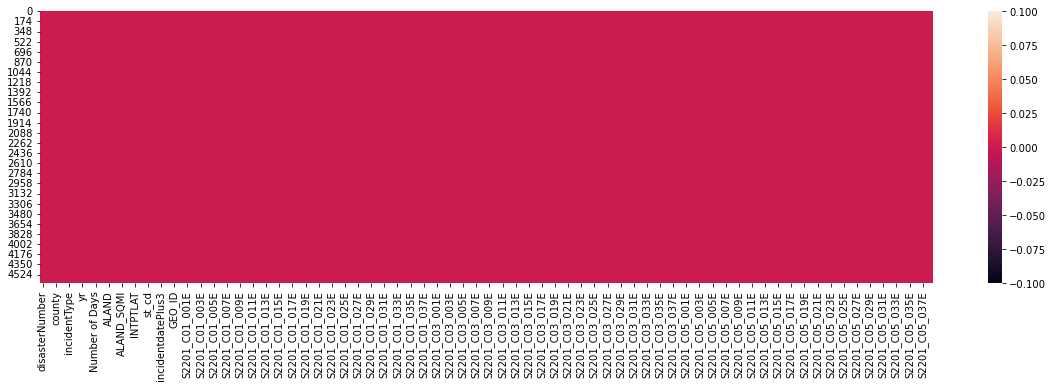

In [31]:
#Merge the fema data and the census data
df= pd.merge(df_fema, dfcensus
             , on  = ['year','Fips_county','st_cd','GEOID']
             , how = 'left'
            ).reset_index(drop = True)

#Investigate the output to determine if there are null values
plt.figure(figsize = [20,5])
sns.heatmap(df.isnull());

In [32]:
# df.drop('rainTotals',axis = 1)
# df[~df['rainTotals'].isnull()].head()[['totalValidRegistrations','rainTotals']]

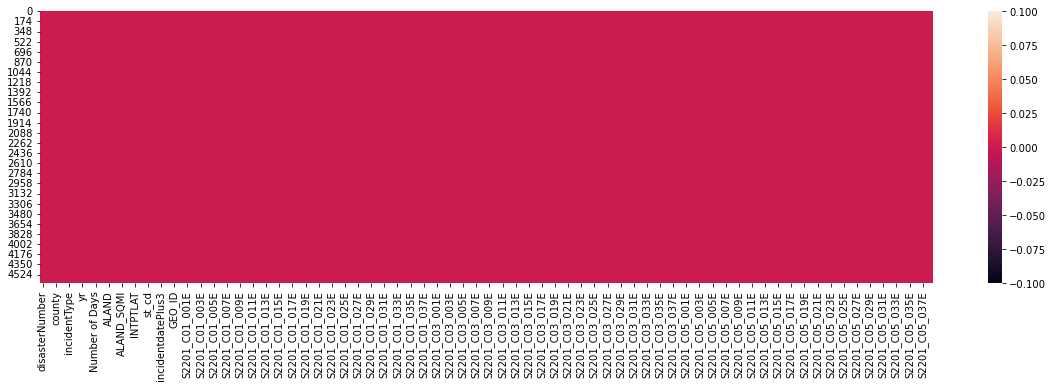

In [33]:
#The null values identified in the above are dropped
df.dropna(axis = 0, inplace = True)
#Output re-investigated
plt.figure(figsize = [20,5])
sns.heatmap(df.isnull());

In [34]:
#The data appears to be highly skewed
df.skew()

disasterNumber             -0.914584
totalValidRegistrations    22.113132
yr                         -1.498052
year                       -1.790060
Number of Days             -0.957175
                             ...    
S2201_C05_034E            -68.344451
S2201_C05_035E             12.573879
S2201_C05_036E             10.516527
S2201_C05_037E             12.885232
S2201_C05_038E             12.644300
Length: 128, dtype: float64

## Look at the Output after a Log Transformation: Full Dataset

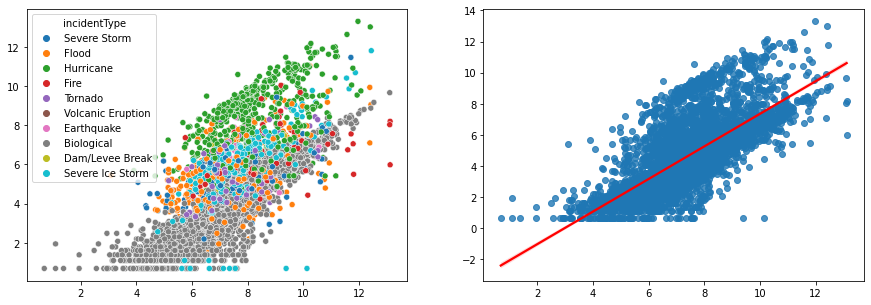

In [35]:
plt.figure(figsize = [15,5])
plt.title('Log Transformed Data')
plt.xlabel('Log Transformed S2201_C01_007E')
plt.ylabel('Log Transformed Valid Registrations')
plt.subplot(1,2,1)
sns.scatterplot(np.log([x+1 for x in df['S2201_C01_007E']])
               ,np.log([x+1 for x in df['totalValidRegistrations']])
               ,hue = df['incidentType']#.astype('category').cat.codes
               )
plt.subplot(1,2,2)
sns.regplot(np.log([x+1 for x in df['S2201_C01_007E']])
           ,np.log([x+1 for x in df['totalValidRegistrations']])
           ,line_kws = {'color':'red'}
            );

## Filter the Dataset for Hurricanes: Create Subdivisions within Hurricane Incident Type
>This section is used to support the idea that creating subdivisions of the data may lead to reduced variance. In all but the bottom quintile, the communityImpact Variable improves the model's performance

In [36]:
#Filter the dataset for only Hurricanes
# df = df[df['totalValidRegistrations']>=10].reset_index(drop = True)
# df_hurricane = df.copy()


dfIncidentType = df[~df['incidentType'].isin(['Biological'
                                            ,'Severe Ice Storm'
                                            ,'Fire','Volcanic Eruption'
                                           ])
                 ].reset_index(drop = True)



In [37]:
df_hurricane = dfIncidentType.copy()

# Sub-Divide the Registration Data By Creating a Feature:
> The communityImpact feature subdivides the data and has a very high Pearson Correlation value

In [38]:

## dfDisaster = df_hurricane[~df_['incidentType'].isin(['Biological','Severe Ice Storm','Fire','Volcano'])].reset_index(drop = True)

dfDisaster = dfIncidentType.groupby('disasterNumber')['totalValidRegistrations'].sum()
dfDisaster = dfDisaster.reset_index()
dfDisaster['disasterSize']= pd.qcut(dfDisaster.loc[:,'totalValidRegistrations']
                                   ,5
                                   ,labels =["Very Small","Small"
                                            ,"Medium" ,"Large"
                                            ,"Very Large"
                                            ]
                                   )
dfDisaster['disasterSize']= dfDisaster['disasterSize'].map({"Very Small":0
                                                            ,"Small":0
                                                            , "Medium":0
                                                            , "Large":0
                                                            , "Very Large":1
                                                            }
                                                           )

dfDisaster = dfDisaster[['disasterNumber','disasterSize']]

dfIncidentType = pd.merge(dfIncidentType,dfDisaster, on ='disasterNumber', how = 'left')
# df_hurricane.head()

In [39]:


# Subdivide the disasters into 5 groups using the ratio of the number of registrations by househould
dfIncidentType['communityImpact']= pd.qcut(dfIncidentType.loc[:,'totalValidRegistrations']\
                                        /dfIncidentType.loc[:,'S2201_C01_001E']#Number of Households
                                        ,5
                                        ,labels =["Very Low"
                                                 ,"Low"
                                                 , "Medium"
                                                 , "Large"
                                                 #, "Very Large"
                                                 , "Catastrophic"
                                             ]
                                        )

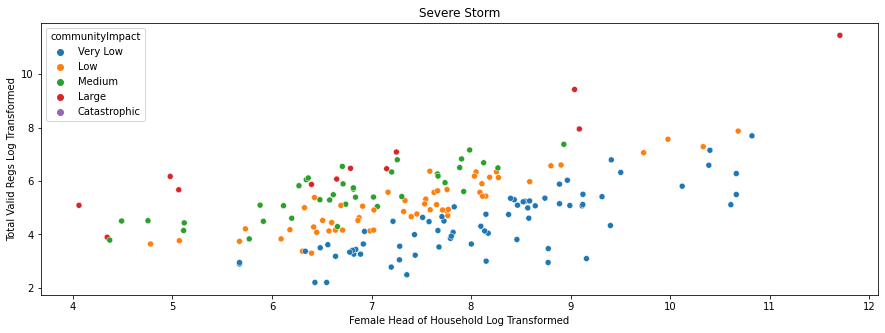

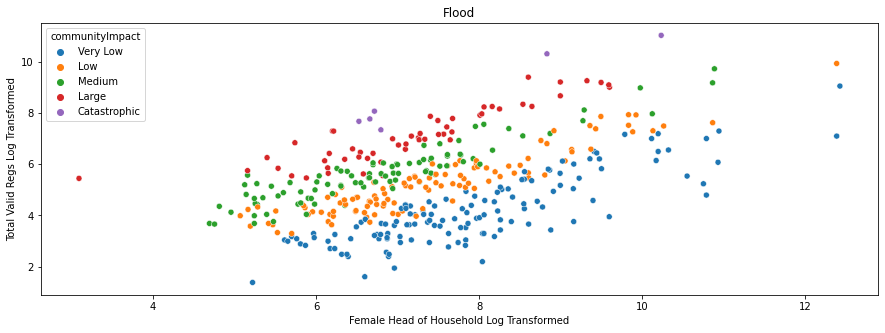

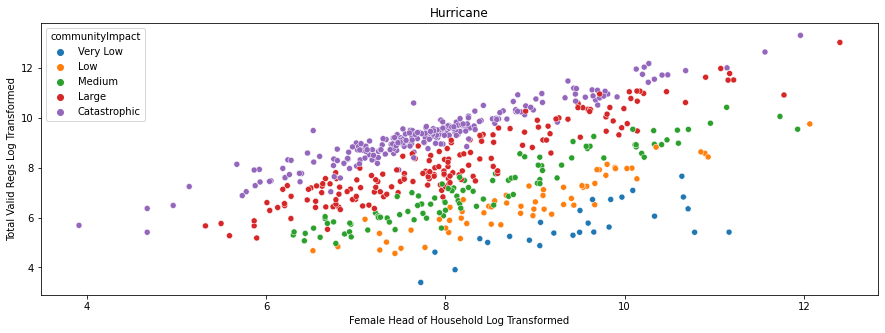

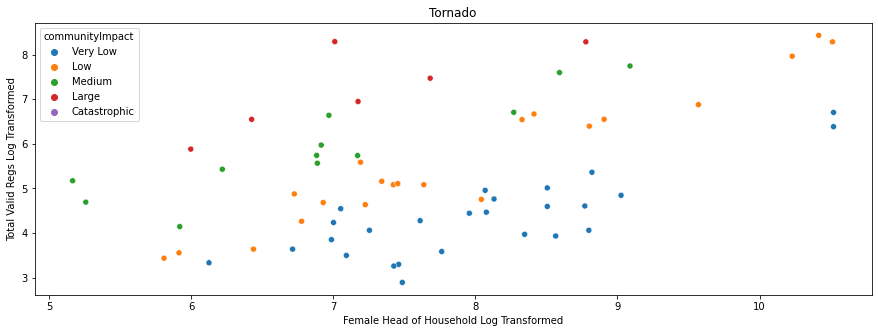

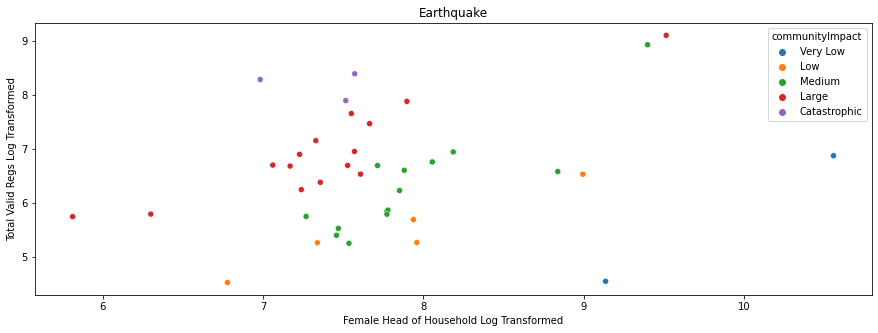

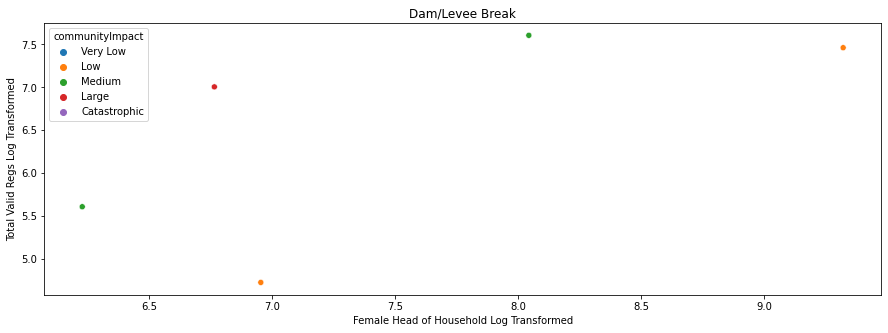

In [40]:
for incidentType in df_hurricane['incidentType'].unique():
    plt.figure(figsize=[15,5])
    plt.title(incidentType)
    plt.xlabel('Female Head of Household Log Transformed')
    plt.ylabel('Total Valid Regs Log Transformed')
    df_type = dfIncidentType[dfIncidentType['incidentType']==incidentType]
    sns.scatterplot(np.log([x+1 for x in df_type['S2201_C01_007E']])
               ,np.log([x+1 for x in df_type['totalValidRegistrations']])
               ,hue = df_type['communityImpact'] 
               )
    plt.show()

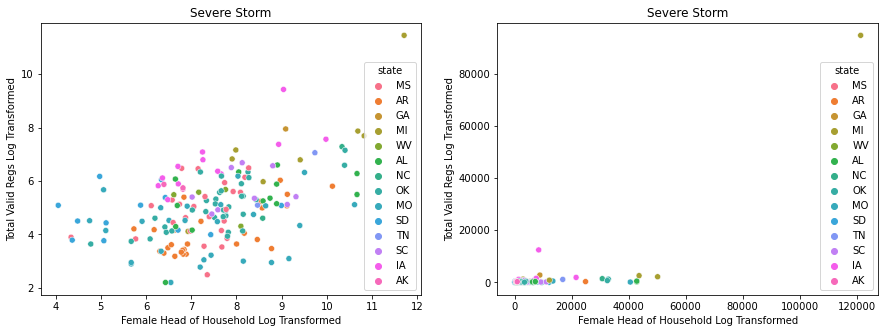

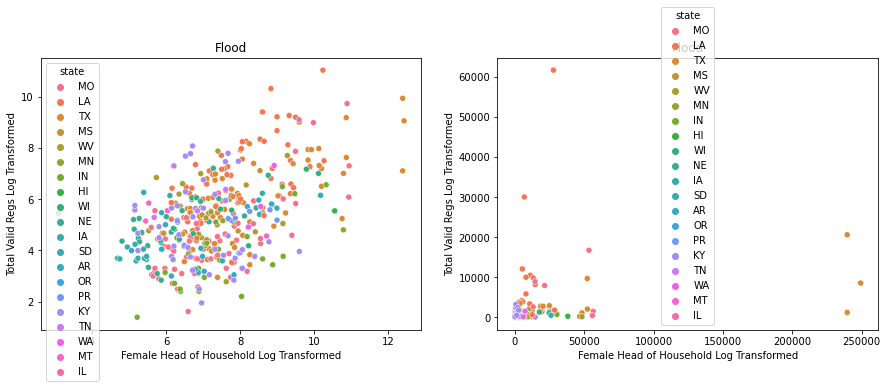

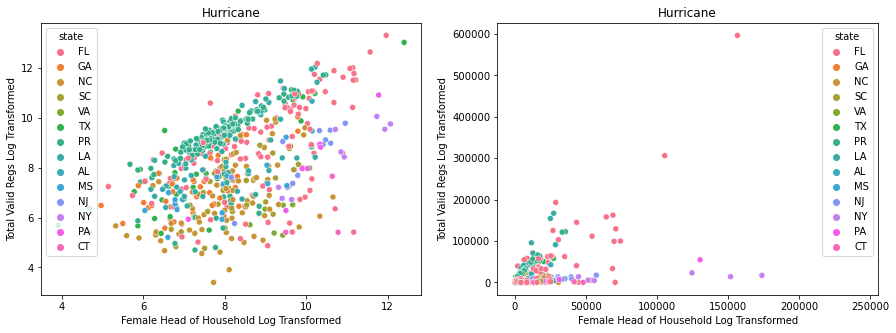

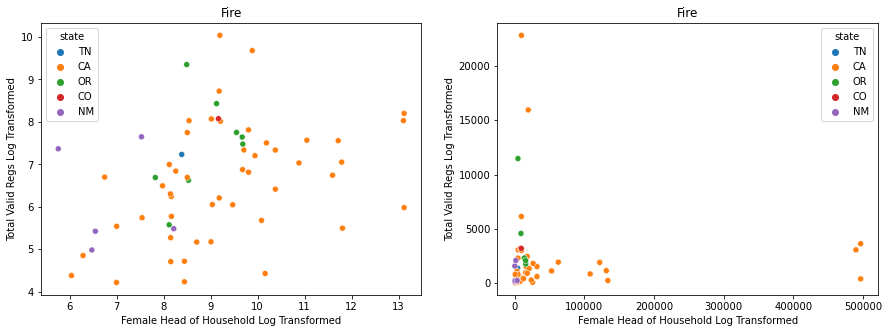

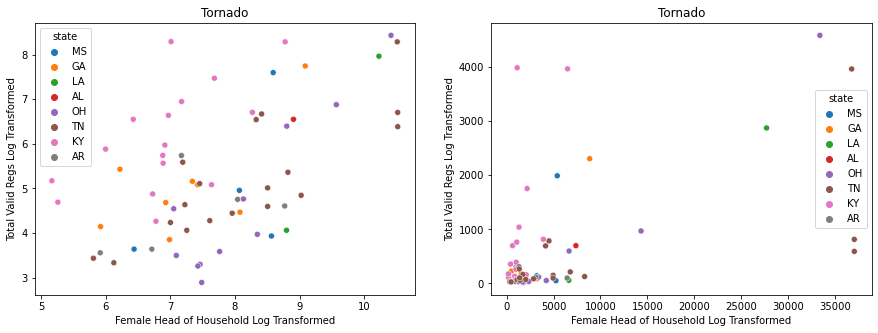

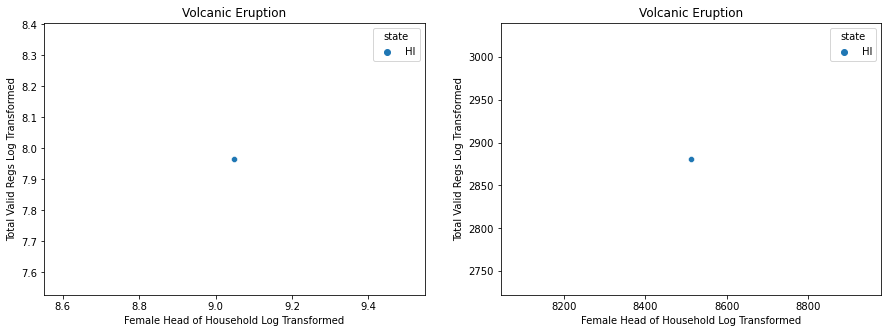

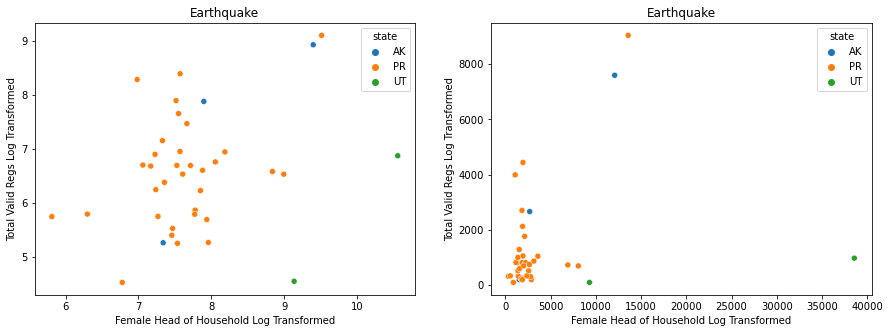

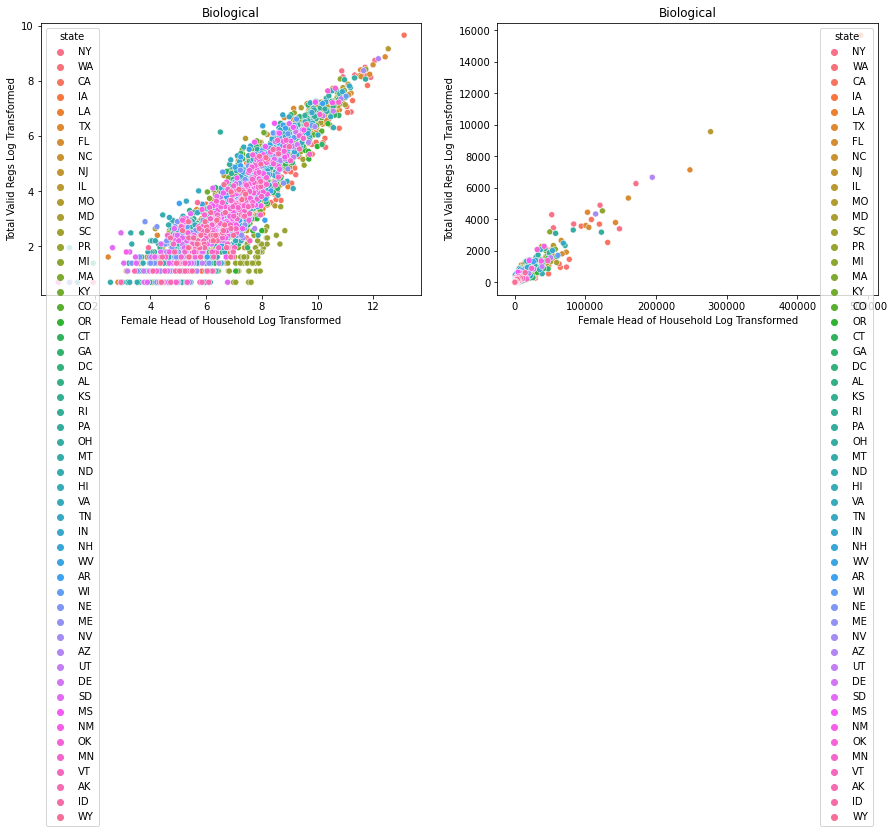

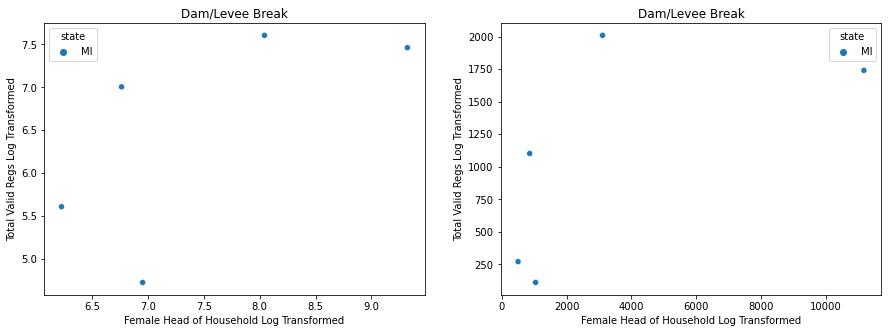

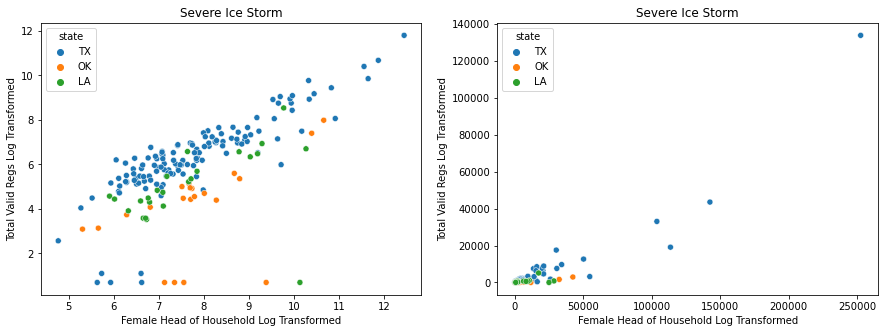

In [41]:
for incidentType in df['incidentType'].unique():
    plt.figure(figsize=[15,5])
    plt.title(incidentType)
#     plt.xlabel('Female Head of Household Log Transformed')
#     plt.ylabel('Total Valid Regs Log Transformed')
    df_type = df[df['incidentType']==incidentType]
    plt.subplot(1,2,1)
    plt.xlabel('Female Head of Household Log Transformed')
    plt.ylabel('Total Valid Regs Log Transformed')
    plt.title(incidentType)
    sns.scatterplot(np.log([x+1 for x in df_type['S2201_C01_007E']])
               ,np.log([x+1 for x in df_type['totalValidRegistrations']])
               ,hue = df_type['state'] 
               )
    plt.subplot(1,2,2)
    plt.title(incidentType)
    plt.xlabel('Female Head of Household Log Transformed')
    plt.ylabel('Total Valid Regs Log Transformed')
    sns.scatterplot(df_type['S2201_C01_007E']
               , df_type['totalValidRegistrations']
               ,hue = df_type['state']
               )
    plt.show()

# 3. Data Preparation: 
* Inspect the Relationship between Female Householders and Registrations:
> While the overall relationship is fairly weak, the subdivided relationship appears to be quite strong in almost all subdivisions; only the very small applications to registration ratio appears to have a moderate relationship. Additionally, an unsupervised model was evaluated below to determine if it could generate similar linear clusters. Because it cannot, a classification model may be necessary to predict the groupings. 

In [42]:
km = KMeans(n_clusters = 5)
y_pred_km = km.fit_predict(dfIncidentType[['S2201_C01_007E','totalValidRegistrations']])
dfIncidentType['cluster'] = y_pred_km

0.4933137274739756


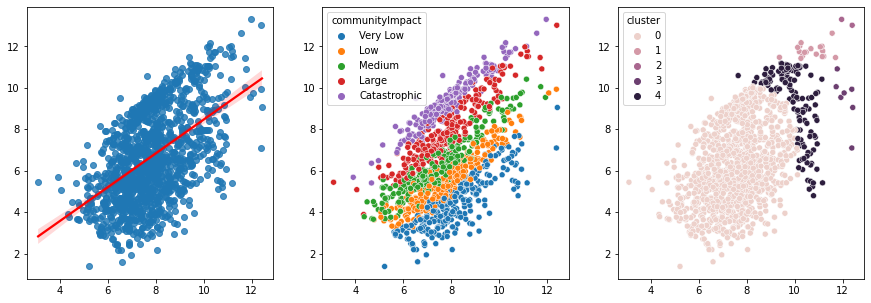

In [43]:
plt.figure(figsize = [15,5])
plt.title('Log Transformed Data')
plt.xlabel('S2201_C01_007E')
plt.subplot(1,3,2)
#Log transformation of Female Householder  
scatter_1 = sns.scatterplot(np.log([x+1 for x in dfIncidentType['S2201_C01_007E']]) #Female householder,
                           ,np.log([x+1 for x in dfIncidentType['totalValidRegistrations']])
                           ,hue = dfIncidentType['communityImpact']#.astype('category').cat.codes
                           )

plt.subplot(1,3,1)
S_corr = dfIncidentType[['totalValidRegistrations','S2201_C01_007E']].corr(method = 'spearman').values[0][1]
print(S_corr)
scatter_2 = sns.regplot(np.log([x+1 for x in dfIncidentType['S2201_C01_007E']])
                        ,np.log([x+1 for x in dfIncidentType['totalValidRegistrations']])
                        ,line_kws = {'color':'red'}
                        )
#
plt.subplot(1,3,3)
# print(S_corr)
scatter_2 = sns.scatterplot(np.log([x+1 for x in dfIncidentType['S2201_C01_007E']])
                        ,np.log([x+1 for x in dfIncidentType['totalValidRegistrations']])
                        ,hue = dfIncidentType['cluster']#rainImpact
                        )


### S2201_C01_002E: Census Variable for People over 60
>Estimate!!Total!!Households!!With one or more people in the household 60 years and over

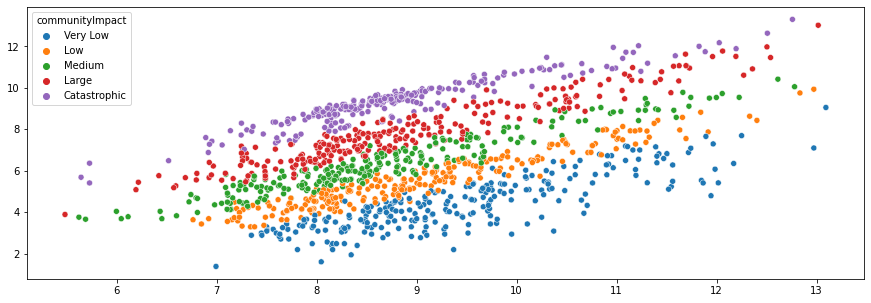

In [44]:
#This is an expanded version of the chart on the right. It appears very linear
plt.figure(figsize = [15,5])
sns.scatterplot(np.log([x+1 for x in dfIncidentType['S2201_C01_002E']])
                ,np.log([x+1 for x in dfIncidentType['totalValidRegistrations']])
                ,hue = dfIncidentType['communityImpact']#
                );

## Regplot: Question 2
>How might we subdivide the data to reduce the variance?: **Create a ratio of Valid Registrations to Households**


### S2201_C01_002E: Elderly

Medium Community Impact: Spearman Correlation 0.94
Very Low Community Impact: Spearman Correlation 0.82
Low Community Impact: Spearman Correlation 0.95
Large Community Impact: Spearman Correlation 0.94
Catastrophic Community Impact: Spearman Correlation 0.93


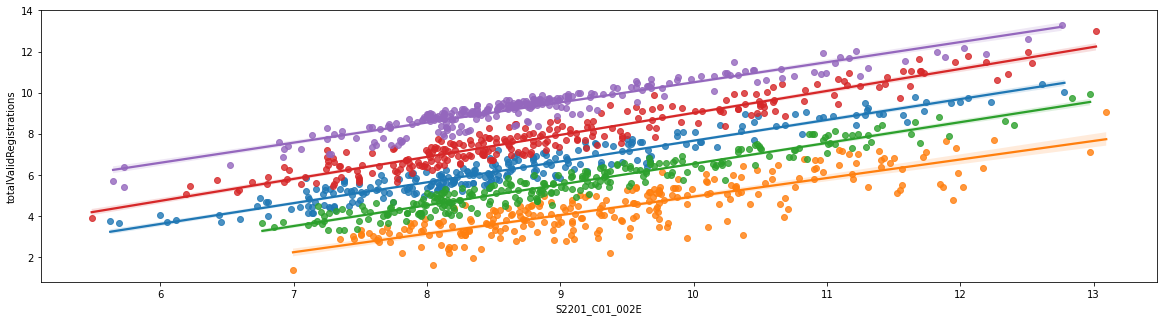

In [45]:
plt.figure(figsize = [20,5])
#Elderly
community_impact('S2201_C01_002E')

### S2201_C01_007E: Female Head of Household

Medium Community Impact: Spearman Correlation 0.93
Very Low Community Impact: Spearman Correlation 0.83
Low Community Impact: Spearman Correlation 0.93
Large Community Impact: Spearman Correlation 0.92
Catastrophic Community Impact: Spearman Correlation 0.94


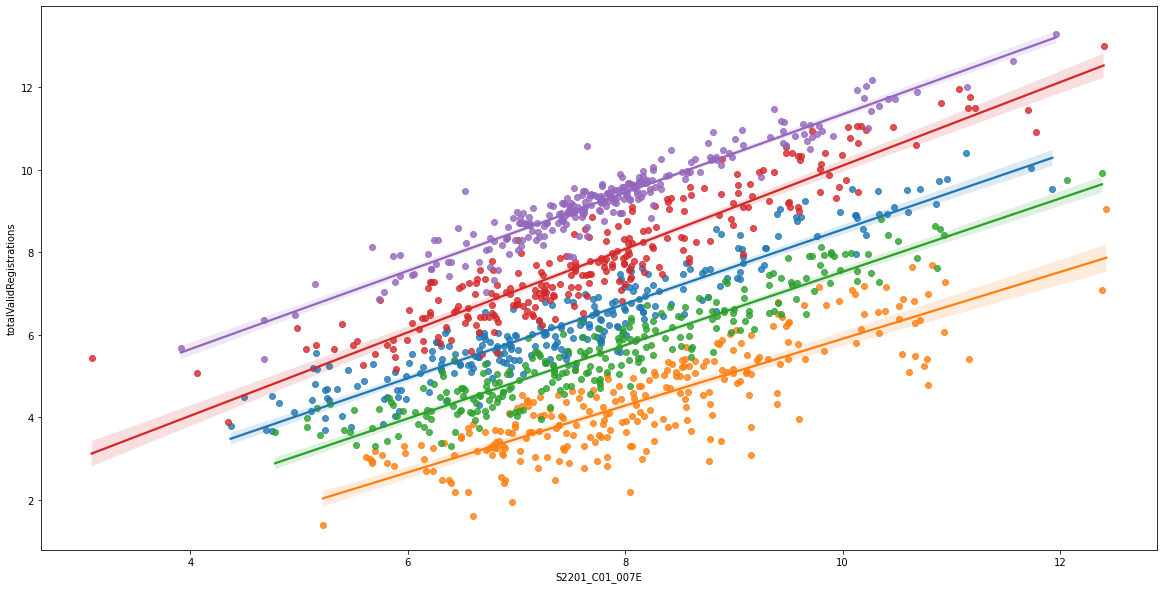

In [46]:
plt.figure(figsize = [20,10])
#Female Head of Household
community_impact('S2201_C01_007E')

### S2201_C01_023E: Disability

Medium Community Impact: Spearman Correlation 0.92
Very Low Community Impact: Spearman Correlation 0.83
Low Community Impact: Spearman Correlation 0.93
Large Community Impact: Spearman Correlation 0.93
Catastrophic Community Impact: Spearman Correlation 0.89


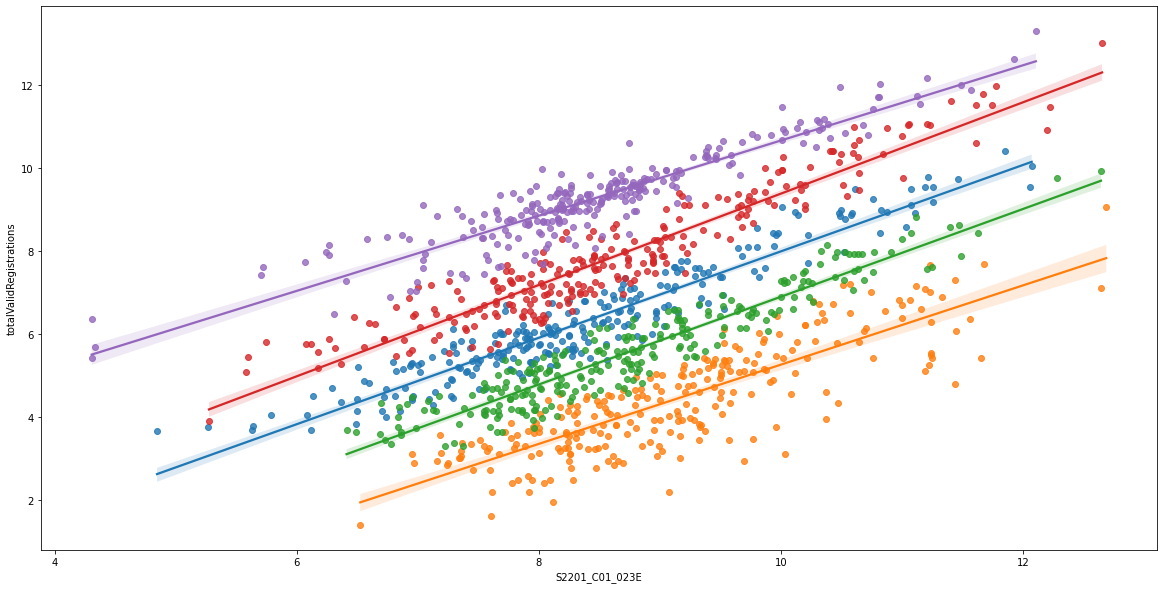

In [47]:
plt.figure(figsize = [20,10])
community_impact('S2201_C01_023E')

### S2201_C03_001E: Supplemental Nutrition Assistance Program

Medium Community Impact: Spearman Correlation 0.88
Very Low Community Impact: Spearman Correlation 0.81
Low Community Impact: Spearman Correlation 0.90
Large Community Impact: Spearman Correlation 0.88
Catastrophic Community Impact: Spearman Correlation 0.90


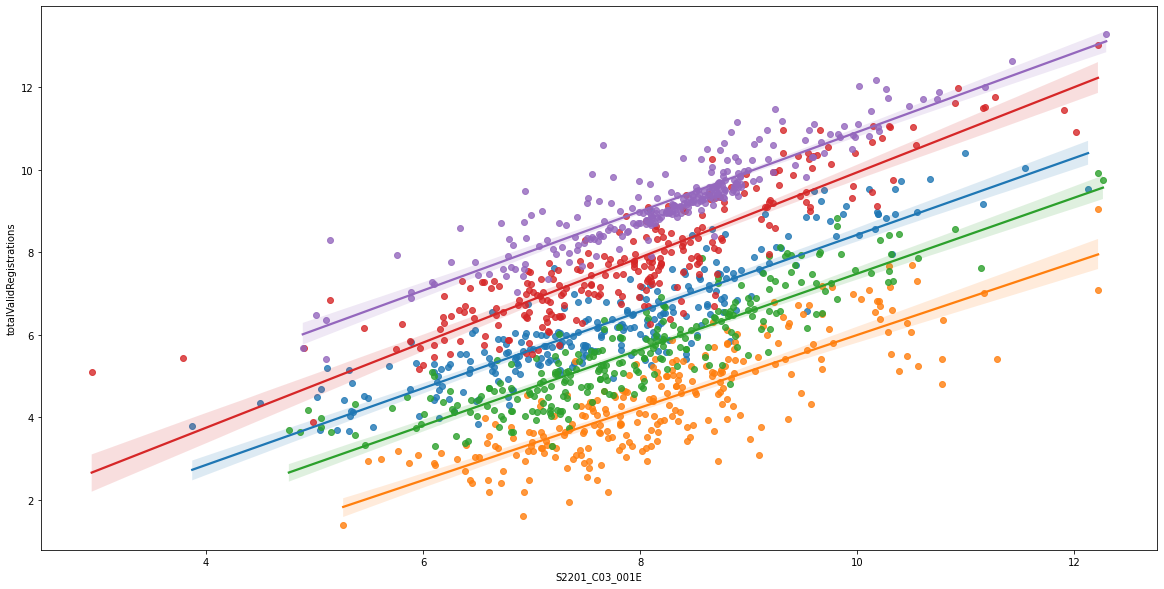

In [48]:
plt.figure(figsize = [20,10])
community_impact('S2201_C03_001E')

## For Each of the Above, the Very Small Disaster had an R^2 of under 70%. 
> Investigated all of the elements in the Table to see if a better result could be identified

In [49]:
df_hurricane = dfIncidentType.copy()


## Feature Selection Begin for Features of Interest

In [50]:
#Filter for the values of interest
df_hurricane = df_hurricane[['totalValidRegistrations'
                             #,'incidentType'
                             ,'disasterSize'
                             ,'Number of Days'
                             ,'AWATER_SQMI'
                             ,'communityImpact'
                             #Poverty
                             ,'S2201_C01_021E'
                             #Snap
                             ,'S2201_C03_001E'
                             #No workers in past 12 months
                             ,'S2201_C01_036E'
                             #With one or more people with a disability
                             ,'S2201_C01_023E'
                             #Female householder, no spouse present
                             ,'S2201_C01_007E'
                             #With one or more people in the household 60 years and over
                             ,'S2201_C01_002E'
                            ]]


#NOAA Values Removed
# df_hurricane = pd.merge(df_hurricane,noaa_df, on = ['incidentBeginDate','GEOID'], how = 'inner')
# df_hurricane.drop(['incidentBeginDate','GEOID'], axis = 1, inplace = True)
#Log-transform the data to ensure linearity




for col in df_hurricane.columns:
    #if col in ['communityImpact','disasterSize','incidentType']: #'Number of Days' is only sometimes skewed
    if col in ['communityImpact','disasterSize','PRCP']:
        continue
    try:
        df_hurricane[f'{col}'] = np.log([x+1 for x in df_hurricane[f'{col}']])
    except:
        pass

#Convert the Incident Type and Community Impact to Dummies
df_hurricane = pd.get_dummies(df_hurricane, columns = ['communityImpact',
                                                       #'incidentType'
                                                      ], drop_first = True)


# Review the Data Skew
# df_hurricane.skew()

In [51]:
df_hurricane.columns

Index(['totalValidRegistrations', 'disasterSize', 'Number of Days',
       'AWATER_SQMI', 'S2201_C01_021E', 'S2201_C03_001E', 'S2201_C01_036E',
       'S2201_C01_023E', 'S2201_C01_007E', 'S2201_C01_002E',
       'communityImpact_Low', 'communityImpact_Medium',
       'communityImpact_Large', 'communityImpact_Catastrophic'],
      dtype='object')

## Appears to be some multi-collinearity. 
1. For S2201_C01_007E/S2201_C01_002E, we will use the Lasso Coeficients mitigate it
2. There is concern about creating a confounding variable. CommunityImpact uses households and valid Registrations
    * There does not appear to be a correlation between the dummy variables and the target or indpendent Vars
    * Therefore Moved forward with this forecast

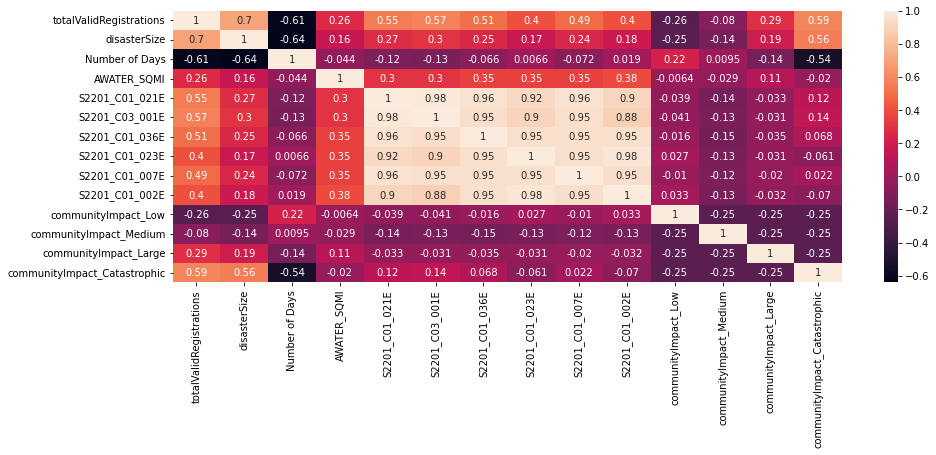

In [52]:
#Use the Heatmap to investigate for multi-collinearity
plt.figure(figsize = [15,5])
df_hurricane.skew()
sns.heatmap(df_hurricane.corr(method = 'spearman'), annot = True);


## 4. Begin Modeling

In [53]:
#Split the data to look at the P-Values
y = df_hurricane['totalValidRegistrations'].values.reshape(-1, 1)
X = df_hurricane.drop(['totalValidRegistrations'], axis = 1).reset_index(drop = True)


In [54]:
names = X.columns

## Investigate Null Values
> No values were dropped, but before modeling this is a good check. 

In [55]:
# plt.figure(figsize= [15,5])

#The model will break if there are nulls, this is the last check for nulls before modeling
# sns.heatmap(X.isnull())

In [56]:
#Split the data
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size=0.3, random_state=42
                                                 , shuffle=False,# stratify=True
                                             )
#For the visualization below, the column names are required as a list
# names = X_train.columns

In [57]:
#Random Forest Regression
rfr = RFR(n_estimators = 1000, criterion = 'squared_error', random_state = 42)
rfr.fit(X_train,y_train.flatten())


RandomForestRegressor(n_estimators=1000, random_state=42)

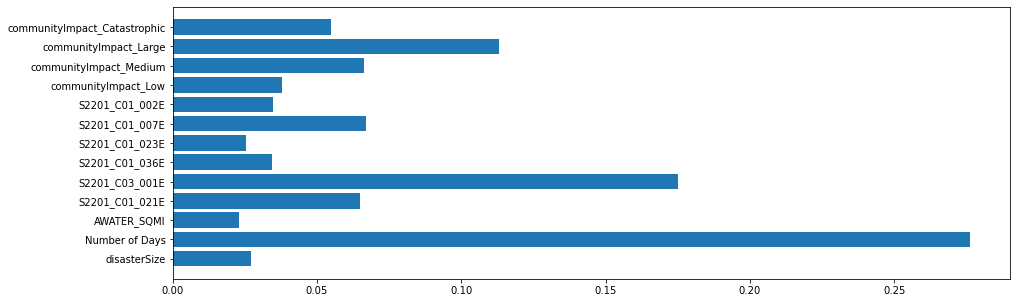

Feature Importance Values:
 [0.02719842 0.27612693 0.02285894 0.06483516 0.17512991 0.03429667
 0.02554079 0.06700488 0.03479555 0.03774507 0.06634524 0.11309037
 0.05503207]


In [58]:
#Visually inspect the feature importances: None are listed at zero
plt.figure(figsize = [15,5])
plt.barh(names,rfr.feature_importances_)
plt.show();
print('Feature Importance Values:\n',rfr.feature_importances_)

In [59]:
#This is the first prediction with the available information using Random Forest
rfr_pred = rfr.predict(X_test)
rfr_score = r2_score(y_test,rfr_pred)
rfr_score

0.8319059506981804

# 5. Evaluation: Begin Processing the Data:
1. Remove Values with High P-Values
2. Use the Lasso Coeficients to determine features of importance
> The idea for the below dictionary came from the following location: https://www.statology.org/statsmodels-linear-regression-p-value

## Question 3: Relationship between geographic elements and target variable
>In the below output, we see that Area of Water Square Miles has a p-value above 0.05 therefore, we exclude it and can determine that water square miles is not a good indicator. 

In [60]:
#R^2 and Adjusted R^2 are very high. Some elements have very high p-values. Must be removed/
X_train_sm = sm.add_constant(X_train)
linreg = sm.OLS( y_train,  X_train_sm ).fit()
print(linreg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     324.0
Date:                Tue, 10 Jan 2023   Prob (F-statistic):          9.42e-195
Time:                        14:00:14   Log-Likelihood:                -260.76
No. Observations:                 389   AIC:                             549.5
Df Residuals:                     375   BIC:                             605.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [61]:
#Create a dictionary to assign the P-Values to the Elements
 #While the AWATER_SQMI is part of the variables that lead to a high R^2,
 #the P-Value is also high and is therefore removed
pvalue_dict = {}
for n,cols in enumerate(X.columns):
    try:
        pvalue_dict[cols] = linreg.pvalues.loc[cols]
    except:
        continue
pvalue_dict

{'disasterSize': 0.6556467859842948,
 'Number of Days': 0.040537353523155975,
 'AWATER_SQMI': 0.9259068348680057,
 'S2201_C01_021E': 0.11406215908633038,
 'S2201_C03_001E': 0.004162840073886657,
 'S2201_C01_036E': 0.056099608912173846,
 'S2201_C01_023E': 0.07696230992954635,
 'S2201_C01_007E': 2.3088377496529485e-05,
 'S2201_C01_002E': 0.9020106111267917,
 'communityImpact_Low': 3.6174415225657186e-60,
 'communityImpact_Medium': 2.871002161936683e-98,
 'communityImpact_Large': 1.8998471465652739e-122,
 'communityImpact_Catastrophic': 1.692250417136694e-83}

In [62]:
#Create a dataFrame that removes any element with a P-Value greater than 0.05
df_pvalue = pd.DataFrame()
column=[]
p_value=[]
for key ,value in pvalue_dict.items():
    if value >0.05:
        pass
    else:
        col = pd.Series(key)
        val = pd.Series(value)
        column.append(col)
        p_value.append(val)
        
df_pvalue['ColumnName'] = pd.Series(column)
df_pvalue['p_value'] = pd.Series(p_value)
df_pvalue['ColumnName'] = df_pvalue['ColumnName'].astype(str).str.lstrip(' ')
df_pvalue['ColumnName'] = df_pvalue['ColumnName'].str.split('\n', expand = True)[0]
df_pvalue['ColumnName']= df_pvalue['ColumnName'].str.split('0  ', expand = True)[1]
columns =list(df_pvalue['ColumnName'].str.strip(' '))

#Filter the columns for the X Variable using the output from the above transformation
X = X[columns]

#Split the data
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size=0.3, random_state=42
                                                 , shuffle=False,# stratify=True
                                                )
#Again use the Names to create a list of columns for the Lasso Visualization
names = X_train.columns
names

Index(['Number of Days', 'S2201_C03_001E', 'S2201_C01_007E',
       'communityImpact_Low', 'communityImpact_Medium',
       'communityImpact_Large', 'communityImpact_Catastrophic'],
      dtype='object')

In [63]:
#Split the data into test and train
# X = X.drop('S2201_C01_002E',axis = 1)
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size=0.3, random_state=42
                                                 , shuffle=False,# stratify=True
                                                )

In [64]:
# Use stats models api to check the P-Value and the adjusted R^2
# See how close the R^2 and adjusted R^2 are. P-values near zero
X_train_sm = sm.add_constant(X_train)
linreg = sm.OLS( y_train, X_train_sm ).fit()
print(linreg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     516.3
Date:                Tue, 10 Jan 2023   Prob (F-statistic):          4.54e-190
Time:                        14:00:14   Log-Likelihood:                -290.73
No. Observations:                 389   AIC:                             597.5
Df Residuals:                     381   BIC:                             629.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [65]:
#Create a dictionary to assign the P-Values to the Elements
 #While the AWATER_SQMI is part of the variables that lead to a high R^2,
 #the P-Value is also high and is therefore removed
pvalue_dict = {}
for n,cols in enumerate(X.columns):
    try:
        pvalue_dict[cols] = linreg.pvalues.loc[cols]
    except:
        continue
pvalue_dict

{'Number of Days': 0.08820207416832587,
 'S2201_C03_001E': 0.7622647547713188,
 'S2201_C01_007E': 7.023788408958056e-16,
 'communityImpact_Low': 6.581041279180266e-52,
 'communityImpact_Medium': 1.1671581181007295e-89,
 'communityImpact_Large': 2.993038796761046e-117,
 'communityImpact_Catastrophic': 1.397754179337869e-79}

In [66]:
#Create a dataFrame that removes any element with a P-Value greater than 0.05
df_pvalue = pd.DataFrame()
column=[]
p_value=[]
for key ,value in pvalue_dict.items():
    if value >0.05:
        pass
    else:
        col = pd.Series(key)
        val = pd.Series(value)
        column.append(col)
        p_value.append(val)
        
df_pvalue['ColumnName'] = pd.Series(column)
df_pvalue['p_value'] = pd.Series(p_value)
df_pvalue['ColumnName'] = df_pvalue['ColumnName'].astype(str).str.lstrip(' ')
df_pvalue['ColumnName'] = df_pvalue['ColumnName'].str.split('\n', expand = True)[0]
df_pvalue['ColumnName']= df_pvalue['ColumnName'].str.split('0  ', expand = True)[1]
columns =list(df_pvalue['ColumnName'].str.strip(' '))

#Filter the columns for the X Variable using the output from the above transformation
X = X[columns]

#Split the data
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size=0.3, random_state=42
                                                 , shuffle=False,# stratify=True
                                                )
#Again use the Names to create a list of columns for the Lasso Visualization
names = X_train.columns
names

Index(['S2201_C01_007E', 'communityImpact_Low', 'communityImpact_Medium',
       'communityImpact_Large', 'communityImpact_Catastrophic'],
      dtype='object')

# Use Lasso for Feature Selection

In [67]:
#Lasso regularization for feature selection
lasso = Lasso()
lasso.fit(X_train,y_train)
#Visualize the coefficients. Unused coefficients will go to zero
lasso_coef = lasso.coef_

In [68]:
## Question 1: Which Feature has the highest utility in a model##
            ## Answer: S2201_C01_002E ##
    ## Reasoning: Lasso Regularization Vizualization ##

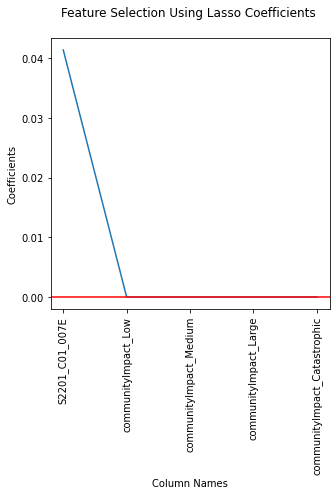

In [69]:
#Used for Feature Selection: 
 #The visualization indicates Households with sixty or greater is the best predictor variable
plt.figure(figsize = [5,5])

lasso1 = plt.plot(range(len(names)),lasso_coef)
plt.xticks(range(len(names)),names, rotation = 90)
plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.ylabel('Coefficients')
plt.xlabel('Column Names')
plt.title('Feature Selection Using Lasso Coefficients \n')

# plt.savefig('Lasso Feature Selection.jpg')
plt.show();

In [70]:
# # Reduce the number of columns to only those that are identified by Lasso with a coef>0
# #  Because we know that the community impact is important to subdiving the data, 
# #  only S2201 columns are removed. 
if len(lasso_coef)>1:
    data = zip(names,lasso_coef)
    data = pd.DataFrame(data)
    column_drop = data[data[0].str.contains('S2201')& (data[1]==0)][0].values
    X = X.drop(column_drop, axis = 1)
    print('complete Lasso: ','There are {} columns'.format(len(lasso_coef)))
else:
    X=X
    print('incomplete Lasso: ','There are {} columns'.format(len(lasso_coef)))

X.columns


complete Lasso:  There are 5 columns


Index(['S2201_C01_007E', 'communityImpact_Low', 'communityImpact_Medium',
       'communityImpact_Large', 'communityImpact_Catastrophic'],
      dtype='object')

In [71]:
# X.drop('S2201_C01_007E',axis =1, inplace = True)

# Evaluate the Final Models

In [72]:
#Split the data into test and train
# X = X.drop('S2201_C01_002E',axis = 1)
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size=0.3, random_state=42
                                                 , shuffle=False,# stratify=True
                                                )

In [73]:
# Use stats models api to check the P-Value and the adjusted R^2
# See how close the R^2 and adjusted R^2 are. P-values near zero
X_train_sm = sm.add_constant(X_train)
linreg = sm.OLS( y_train, X_train_sm ).fit()
print(linreg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     720.5
Date:                Tue, 10 Jan 2023   Prob (F-statistic):          2.71e-192
Time:                        14:00:14   Log-Likelihood:                -292.22
No. Observations:                 389   AIC:                             596.4
Df Residuals:                     383   BIC:                             620.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [74]:
#Create a dictionary to assign the P-Values to the Elements
 #While the AWATER_SQMI is part of the variables that lead to a high R^2,
 #the P-Value is also high and is therefore removed
pvalue_dict = {}
for n,cols in enumerate(X.columns):
    try:
        pvalue_dict[cols] = linreg.pvalues.loc[cols]
    except:
        continue
pvalue_dict

{'S2201_C01_007E': 1.7923430505146401e-134,
 'communityImpact_Low': 2.214463645935614e-58,
 'communityImpact_Medium': 8.753442090552238e-111,
 'communityImpact_Large': 1.7102869527835773e-149,
 'communityImpact_Catastrophic': 3.1037366637986536e-90}

In [75]:
#Create a dataFrame that removes any element with a P-Value greater than 0.05
df_pvalue = pd.DataFrame()
column=[]
p_value=[]
for key ,value in pvalue_dict.items():
    if value >0.05:
        pass
    else:
        col = pd.Series(key)
        val = pd.Series(value)
        column.append(col)
        p_value.append(val)
        
df_pvalue['ColumnName'] = pd.Series(column)
df_pvalue['p_value'] = pd.Series(p_value)
df_pvalue['ColumnName'] = df_pvalue['ColumnName'].astype(str).str.lstrip(' ')
df_pvalue['ColumnName'] = df_pvalue['ColumnName'].str.split('\n', expand = True)[0]
df_pvalue['ColumnName']= df_pvalue['ColumnName'].str.split('0  ', expand = True)[1]
columns =list(df_pvalue['ColumnName'].str.strip(' '))

#Filter the columns for the X Variable using the output from the above transformation
X = X[columns]

#Split the data
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size=0.3, random_state=42
                                                 , shuffle=False,# stratify=True
                                                )
#Again use the Names to create a list of columns for the Lasso Visualization
names = X_train.columns
names

Index(['S2201_C01_007E', 'communityImpact_Low', 'communityImpact_Medium',
       'communityImpact_Large', 'communityImpact_Catastrophic'],
      dtype='object')

In [76]:
#Split the data into test and train
# X = X.drop('S2201_C01_002E',axis = 1)
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size=0.3, random_state=42
                                                 , shuffle=False,# stratify=True
                                                )

In [77]:
# Use stats models api to check the P-Value and the adjusted R^2
# See how close the R^2 and adjusted R^2 are. P-values near zero
X_train_sm = sm.add_constant(X_train)
linreg = sm.OLS( y_train, X_train_sm ).fit()
print(linreg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     720.5
Date:                Tue, 10 Jan 2023   Prob (F-statistic):          2.71e-192
Time:                        14:00:14   Log-Likelihood:                -292.22
No. Observations:                 389   AIC:                             596.4
Df Residuals:                     383   BIC:                             620.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [78]:
#Lasso Regularization Forecast
lasso.fit(X_train,y_train)
lasso_pred = lasso.predict(X_test)
lasso_score = r2_score(y_test,lasso_pred)
# print the R^2 Value of Lasso score
lasso_score

-0.3422416625185565

In [79]:
#Linear Regression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

lr_score = r2_score(y_test,y_pred)

# print the R^2 Value of score
lr_score

0.934164269407191

In [80]:
#Random Forest Regression
rfr = RFR(n_estimators = 1000, criterion = 'squared_error', random_state = 42)
rfr.fit(X_train,y_train.flatten())
rfr_pred = rfr.predict(X_test)
rfr_score = r2_score(y_test,rfr_pred)
rfr_score

0.8594535673581034

In [81]:

#MSE lr: Not rmse because values are log transformed
lr_mse = mean_squared_error(y_test,y_pred)
lr_rmse = np.sqrt(lr_mse)

#MSE Lasso
lasso_mse = mean_squared_error(y_test,lasso_pred)
lasso_rmse = np.sqrt(lasso_mse)

#MSE rfr
rfr_mse = mean_squared_error(y_test,rfr_pred)
rfr_rmse = np.sqrt(rfr_mse)

print('The Linear Regression Mean Squared error is: {:.3f}'.format(lr_rmse))
print('The Lasso Regression Mean Squared error is: {:.3f}'.format(lasso_rmse))
print('The Random Forest Mean Squared error is: {:.3f}'.format(rfr_rmse))

The Linear Regression Mean Squared error is: 0.575
The Lasso Regression Mean Squared error is: 2.597
The Random Forest Mean Squared error is: 0.840


In [82]:
#Compare the R^2 results
print('The Linear Regression r^2 value for this model is: {:.2f}'.format(lr_score))
print('The Lasso Regression r^2 value for this model is: {:.2f}'.format(lasso_score))
print('The Random Forest r^2 value for this model is: {:.2f}'.format(rfr_score))

The Linear Regression r^2 value for this model is: 0.93
The Lasso Regression r^2 value for this model is: -0.34
The Random Forest r^2 value for this model is: 0.86


# Create a DataFrame to Review the Outputs

In [83]:
#Visually inspect the outputs
df_results = pd.DataFrame(y_pred, columns =['y_pred'])
df_results = pd.DataFrame(zip(y_test.flatten(),y_pred.flatten()), columns = ['y_test','y_pred'])
df_results['y_test_transformed'] = round(np.exp(df_results['y_test']),0)
df_results['y_pred_transformed'] = round(np.exp(df_results['y_pred']),0)

In [84]:
df_results.head(50)

,y_test,y_pred,y_test_transformed,y_pred_transformed
0,6.705639,6.473542,817.0,648.0
1,10.974215,9.646958,58350.0,15475.0
2,10.709629,10.823759,44785.0,50199.0
3,7.035269,7.528604,1136.0,1861.0
4,6.416732,6.771860,612.0,873.0
5,6.001415,6.018570,404.0,411.0
6,9.231319,9.245513,10212.0,10358.0
7,13.015535,11.497609,449340.0,98480.0
8,7.767687,8.050681,2363.0,3136.0
9,8.363576,8.736333,4288.0,6225.0


In [85]:
df_results.tail(50)

,y_test,y_pred,y_test_transformed,y_pred_transformed
859,9.021115,8.980769,8276.0,7949.0
860,9.976645,9.884829,21518.0,19630.0
861,10.257905,10.088123,28507.0,24056.0
862,9.930908,9.891731,20556.0,19766.0
863,9.388570,9.068140,11951.0,8674.0
864,9.474088,9.296800,13018.0,10903.0
865,9.997433,9.624551,21970.0,15132.0
866,7.722235,7.935988,2258.0,2796.0
867,9.094480,9.036205,8906.0,8402.0
868,9.451167,9.266202,12723.0,10575.0


In [86]:
df_results['Residuals'] = df_results['y_test'] - df_results['y_pred']

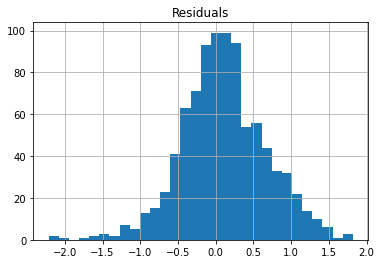

In [87]:
#Check to see if the residuals are Normally Distributed
#This check helps to determine the accuracy of the model
df_results.hist('Residuals', bins=30);

In [88]:
df_results['Residuals'].skew()

-0.10510190983296833

In [89]:
df_results[df_results['Residuals']< -2]

,y_test,y_pred,y_test_transformed,y_pred_transformed,Residuals
187,2.197225,4.359508,9.0,78.0,-2.162283
406,2.944439,4.980796,19.0,146.0,-2.036357
416,3.091042,5.306428,22.0,202.0,-2.215385


In [90]:
df_hurricane.count()[0]

1298

In [91]:
# dfx = df_hurricane[~df_hurricane['incidentType'].isin(['Biological','Severe Ice Storm','Fire','Volcano'])].reset_index(drop = True)
# dfx[dfx['communityImpact']=='Catestrophic']['disasterNumber'].unique()

# Build Classification Model to Predict Community Impact

In [2]:
#Copy the dataframe from above
df_communityImpact = dfIncidentType.copy()


NameError: name 'dfIncidentType' is not defined

In [ ]:
# noaa_df = []
# for index, record in df_communityImpact.iterrows():
#     GEOID = record['GEOID']
#     incidentBeginDate = record['incidentBeginDate']
#     incidentDatePlus = record['incidentdatePlus5']
#     dfNoaa = noaa_water(noaaToken, GEOID, incidentBeginDate, incidentDatePlus)
#     noaa_df.append(dfNoaa)
# noaa_df = pd.DataFrame(pd.concat(noaa_df,sort = False))    

In [94]:
#Mean values: Change the function group by statement to mean instead of sum to update this output
noaa_df = pd.read_csv('NoaaTotals.csv')
noaa_df.head()

,GEOID,incidentBeginDate,ADPT,ASLP,ASTP,AWBT,AWDR,AWND,DAPR,EVAP,...,WSFI,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT11
0,1003,2020-09-14,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2.564949,2.734368,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1007,2021-03-25,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2.079442,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,1015,2018-03-19,5.860786,11.017448,10.995595,6.280396,0.0,2.960105,1.945910,0.000000,...,0.0,1.386294,0.693147,0.693147,0.0,0.0,0.0,0.0,0.0,0.0
3,1015,2021-03-25,6.576470,11.019367,10.998025,6.822197,0.0,2.954910,0.000000,0.000000,...,0.0,1.098612,0.000000,1.386294,0.0,0.0,0.0,0.0,0.0,0.0
4,1025,2020-10-28,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
#Review the Skew
noaa_df.skew()

GEOID    -0.035242
ADPT      1.625739
ASLP      1.493205
ASTP      1.493267
AWBT      1.553289
AWDR     22.626045
AWND      0.796790
DAPR      1.103017
EVAP      5.169558
MDPR      0.923089
MNPN      7.606155
MXPN      7.597430
PGTM      3.171054
PRCP     -0.944429
PSUN     31.749016
RHAV      1.496978
RHMN      1.498912
RHMX      1.503913
SN31     13.578159
SN32      4.871042
SN33     18.957441
SN51     18.278635
SN52      5.830173
SN53     31.749016
SNOW      6.323412
SNWD      4.295791
SX31     13.087757
SX32      4.853254
SX33     18.984959
SX51     18.291135
SX52      5.812883
SX53     31.749016
TAVG      1.156040
TMAX     -1.548539
TMIN     -1.166641
TOBS     -0.767765
TSUN     31.749016
WDF2      0.696699
WDF5      0.699288
WDFG     12.178882
WDMV      5.483829
WESD      7.758747
WESF     13.101595
WSF2      0.729503
WSF5      0.721171
WSFG     10.823063
WSFI     23.376008
WT01      0.924363
WT02      2.891982
WT03      1.038950
WT04     15.173175
WT05      7.295110
WT06     11.

In [96]:
for col in noaa_df.columns:
    try:
        if noaa_df[col].skew() > 1.5 or noaa_df[col].skew() < - 1.5:
            noaa_df.drop(col, axis = 1, inplace = True)
    except Exception as e:
        print(e)
noaa_df.skew()

could not convert string to float: '2020-09-14'


GEOID   -0.035242
ASLP     1.493205
ASTP     1.493267
AWND     0.796790
DAPR     1.103017
MDPR     0.923089
PRCP    -0.944429
RHAV     1.496978
RHMN     1.498912
TAVG     1.156040
TMIN    -1.166641
TOBS    -0.767765
WDF2     0.696699
WDF5     0.699288
WSF2     0.729503
WSF5     0.721171
WT01     0.924363
WT03     1.038950
dtype: float64

In [97]:
#Ensure data is structured correctly then merge
df_communityImpact['GEOID'] = df_communityImpact['GEOID'].astype(str)
noaa_df['GEOID'] = noaa_df['GEOID'].astype(str)

df_communityImpact['incidentBeginDate'] = pd.to_datetime(df_communityImpact['incidentBeginDate']).dt.strftime('%Y-%m-%d')

# #Removed because high p-value, and reduced dataset by 1/3
df_communityImpact = pd.merge(df_communityImpact,noaa_df
                       ,on  = ['GEOID','incidentBeginDate']
                       ,how = 'left'
                       ,suffixes = ['_FEMA','_NOAA']
                       )

df_communityImpact.head()

,disasterNumber,state,county,totalValidRegistrations,incidentType,incidentBeginDate,yr,year,Number of Days,GEOID,...,RHMN,TAVG,TMIN,TOBS,WDF2,WDF5,WSF2,WSF5,WT01,WT03
0,4248,MS,Benton (County),159,Severe Storm,2015-12-23,2016,2016,12,28009,...,0.0,0.000000,5.080161,5.341377,0.0,0.0,0.0,0.0,1.098612,1.098612
1,4248,MS,Coahoma (County),271,Severe Storm,2015-12-23,2016,2016,12,28027,...,0.0,0.000000,3.985273,4.435567,0.0,0.0,0.0,0.0,0.000000,0.693147
2,4248,MS,Marshall (County),378,Severe Storm,2015-12-23,2016,2016,12,28093,...,0.0,4.730921,5.080783,0.000000,0.0,0.0,0.0,0.0,1.609438,1.386294
3,4248,MS,Monroe (County),89,Severe Storm,2015-12-23,2016,2016,12,28095,...,0.0,0.000000,4.154185,4.401829,0.0,0.0,0.0,0.0,0.000000,0.000000
4,4248,MS,Panola (County),46,Severe Storm,2015-12-23,2016,2016,12,28107,...,0.0,0.000000,4.976044,5.199049,0.0,0.0,0.0,0.0,0.000000,0.000000


## Create the Community Impact Calculation

In [98]:

# df_communityImpact['timeToDeclaration']= pd.qcut(df_communityImpact.loc[:,'Number of Days']
#                                                 ,2
#                                                 ,labels =["Large","Small"]
#                                                 ) 
df_communityImpact['Month'] = df_communityImpact['incidentBeginDate'].astype(str).str.slice(start=5, stop=7)
df_communityImpact.head()

,disasterNumber,state,county,totalValidRegistrations,incidentType,incidentBeginDate,yr,year,Number of Days,GEOID,...,TAVG,TMIN,TOBS,WDF2,WDF5,WSF2,WSF5,WT01,WT03,Month
0,4248,MS,Benton (County),159,Severe Storm,2015-12-23,2016,2016,12,28009,...,0.000000,5.080161,5.341377,0.0,0.0,0.0,0.0,1.098612,1.098612,12
1,4248,MS,Coahoma (County),271,Severe Storm,2015-12-23,2016,2016,12,28027,...,0.000000,3.985273,4.435567,0.0,0.0,0.0,0.0,0.000000,0.693147,12
2,4248,MS,Marshall (County),378,Severe Storm,2015-12-23,2016,2016,12,28093,...,4.730921,5.080783,0.000000,0.0,0.0,0.0,0.0,1.609438,1.386294,12
3,4248,MS,Monroe (County),89,Severe Storm,2015-12-23,2016,2016,12,28095,...,0.000000,4.154185,4.401829,0.0,0.0,0.0,0.0,0.000000,0.000000,12
4,4248,MS,Panola (County),46,Severe Storm,2015-12-23,2016,2016,12,28107,...,0.000000,4.976044,5.199049,0.0,0.0,0.0,0.0,0.000000,0.000000,12


In [99]:
#Investigate the two halves of the data
# plt.figure(figsize = [20,5])
# sns.scatterplot(df_communityImpact['Number of Days'],df_communityImpact['totalValidRegistrations']
#            ,hue = df_communityImpact['timeToDeclaration'])

In [100]:
# df_communityImpact = pd.get_dummies(df_communityImpact, columns = ['incidentType','timeToDeclaration','Month'], drop_first = True)
df_communityImpact.head()

,disasterNumber,state,county,totalValidRegistrations,incidentType,incidentBeginDate,yr,year,Number of Days,GEOID,...,TAVG,TMIN,TOBS,WDF2,WDF5,WSF2,WSF5,WT01,WT03,Month
0,4248,MS,Benton (County),159,Severe Storm,2015-12-23,2016,2016,12,28009,...,0.000000,5.080161,5.341377,0.0,0.0,0.0,0.0,1.098612,1.098612,12
1,4248,MS,Coahoma (County),271,Severe Storm,2015-12-23,2016,2016,12,28027,...,0.000000,3.985273,4.435567,0.0,0.0,0.0,0.0,0.000000,0.693147,12
2,4248,MS,Marshall (County),378,Severe Storm,2015-12-23,2016,2016,12,28093,...,4.730921,5.080783,0.000000,0.0,0.0,0.0,0.0,1.609438,1.386294,12
3,4248,MS,Monroe (County),89,Severe Storm,2015-12-23,2016,2016,12,28095,...,0.000000,4.154185,4.401829,0.0,0.0,0.0,0.0,0.000000,0.000000,12
4,4248,MS,Panola (County),46,Severe Storm,2015-12-23,2016,2016,12,28107,...,0.000000,4.976044,5.199049,0.0,0.0,0.0,0.0,0.000000,0.000000,12


In [101]:
df_communityImpact['GEOID'] = df_communityImpact['GEOID'].astype(str)
df_communityImpact['yr'] = df_communityImpact['yr'].astype(str)


In [102]:

df_impact = df_communityImpact.drop( ['st_cd','state'
                                     ,'county','yr'
                                     ,'Fips_county','incidentdatePlus3'
                                     ,'incidentdatePlus5','GEO_ID'
                                     ,'GEOID','totalValidRegistrations'
                                     ,'incidentBeginDate', 'year'
                                     ],axis = 1
                                   )

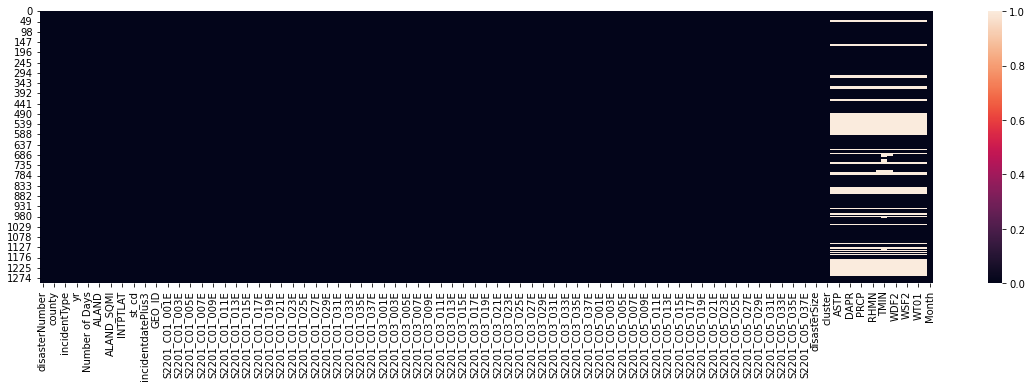

1298


In [103]:
plt.figure(figsize = [20,5])
sns.heatmap(df_communityImpact.isnull())
plt.show();
print(df_impact.count()[0])

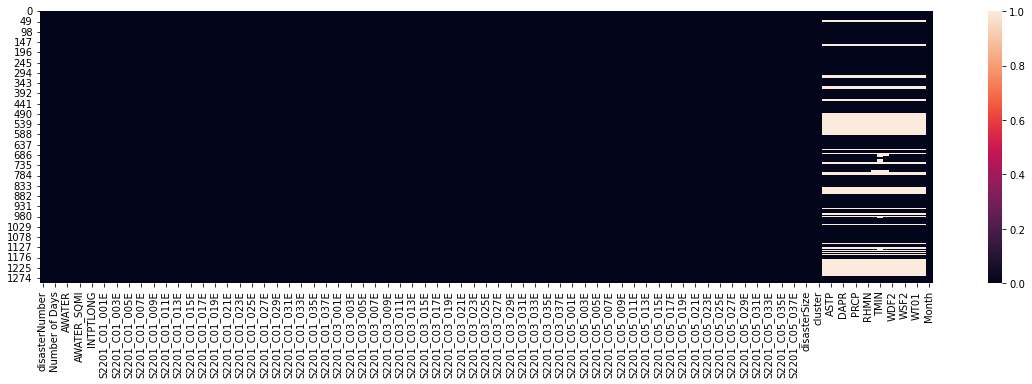

1298


In [104]:
# df_impact = df_communityImpact[column]
plt.figure(figsize = [20,5])
sns.heatmap(df_impact.isnull())
plt.show();
print(df_impact.count()[0])

In [105]:
#Reduce skew with a log transfoormation
for col in df_impact.columns:
    try:
        if  col in['Rural_Urban','communityImpact','INTPTLAT','INTPTLONG','Month','state','disasterSize']:
            continue
        elif 'incidentType' in col or 'timeToDeclaration' in col:
            continue
        else:
            df_impact[col] = np.log([x+1 for x in df_impact.loc[:,col].astype(float)])
    except Exception as e:
        print(e)


# df_impact.head()
df_impact

could not convert string to float: 'Benton County, Mississippi'


,disasterNumber,incidentType,Number of Days,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG,NAME,...,TAVG,TMIN,TOBS,WDF2,WDF5,WSF2,WSF5,WT01,WT03,Month
0,8.354439,Severe Storm,2.564949,20.775034,15.479282,6.010326,1.111199,34.810518,-89.200285,"Benton County, Mississippi",...,0.000000,1.805031,1.847096,0.000000,0.000000,0.000000,0.000000,0.741276,0.741276,12
1,8.354439,Severe Storm,2.564949,21.081664,18.189033,6.316309,3.454011,34.228670,-90.603165,"Coahoma County, Mississippi",...,0.000000,1.606488,1.692964,0.000000,0.000000,0.000000,0.000000,0.000000,0.526589,12
2,8.354439,Severe Storm,2.564949,21.327030,16.034191,6.561281,1.515127,34.766190,-89.504231,"Marshall County, Mississippi",...,1.745876,1.805133,0.000000,0.000000,0.000000,0.000000,0.000000,0.959135,0.869742,12
3,8.354439,Severe Storm,2.564949,21.407161,16.713521,6.641304,2.079816,33.890030,-88.485038,"Monroe County, Mississippi",...,0.000000,1.639809,1.686738,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12
4,8.354439,Severe Storm,2.564949,21.296792,17.762317,6.531086,3.043951,34.365205,-89.963065,"Panola County, Mississippi",...,0.000000,1.787759,1.824396,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1293,8.451267,Hurricane,3.610918,20.953766,19.205530,6.188656,4.450117,29.474891,-81.286253,"Flagler County, Florida",...,0.000000,1.648120,1.657669,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11
1294,8.451267,Hurricane,3.610918,21.625519,20.089983,6.859405,5.327687,28.764113,-81.712282,"Lake County, Florida",...,1.772932,1.981715,1.909594,2.005705,2.054573,1.652403,1.704713,1.026672,0.000000,11
1295,8.451267,Hurricane,3.610918,21.357951,19.357898,6.592159,4.600831,29.593896,-81.732039,"Putnam County, Florida",...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11
1296,8.451267,Hurricane,3.610918,21.165161,20.164848,6.399661,5.402200,29.890487,-81.400040,"St. Johns County, Florida",...,0.000000,1.853080,1.762315,1.994345,2.055986,1.614495,1.661175,0.959135,0.000000,11


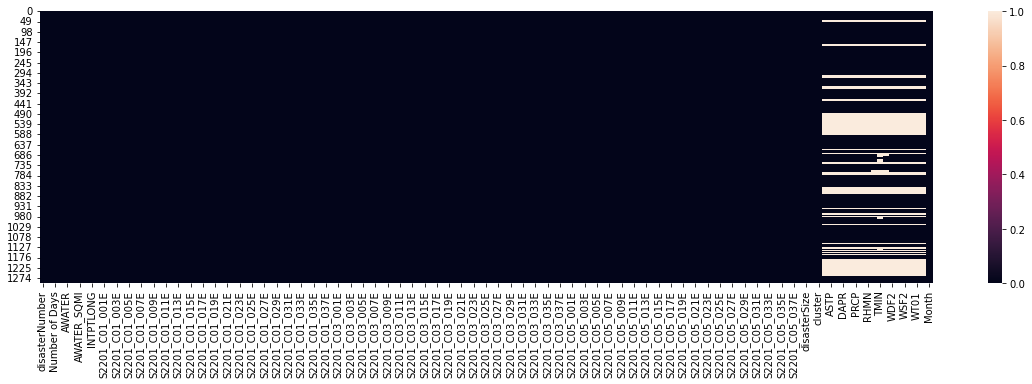

In [106]:
plt.figure(figsize= [20,5])
sns.heatmap(df_impact.isnull());


In [107]:
#Drop Columns that do not impact the output or are categorical
df_impact.drop(['NAME','WDF2','WDF5','WSF2','WSF5','WT01','WT03',
                'MDPR','RHAV','RHMN','ASTP','DAPR','TAVG','ASLP'
               ], axis = 1, inplace = True)


df_impact

,disasterNumber,incidentType,Number of Days,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG,S2201_C01_001E,...,S2201_C05_037E,S2201_C05_038E,disasterSize,communityImpact,cluster,AWND,PRCP,TMIN,TOBS,Month
0,8.354439,Severe Storm,2.564949,20.775034,15.479282,6.010326,1.111199,34.810518,-89.200285,8.047829,...,6.630683,6.558198,0,Medium,0.000000,0.000000,1.801720,1.805031,1.847096,12
1,8.354439,Severe Storm,2.564949,21.081664,18.189033,6.316309,3.454011,34.228670,-90.603165,9.114380,...,7.198931,7.275865,0,Medium,0.000000,0.000000,1.928452,1.606488,1.692964,12
2,8.354439,Severe Storm,2.564949,21.327030,16.034191,6.561281,1.515127,34.766190,-89.504231,9.489032,...,8.005367,8.166216,0,Medium,0.000000,0.000000,1.907743,1.805133,0.000000,12
3,8.354439,Severe Storm,2.564949,21.407161,16.713521,6.641304,2.079816,33.890030,-88.485038,9.543235,...,7.884953,8.200014,0,Very Low,0.000000,0.000000,1.880035,1.639809,1.686738,12
4,8.354439,Severe Storm,2.564949,21.296792,17.762317,6.531086,3.043951,34.365205,-89.963065,9.407961,...,7.768110,7.949797,0,Very Low,0.000000,0.000000,1.922584,1.787759,1.824396,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1293,8.451267,Hurricane,3.610918,20.953766,19.205530,6.188656,4.450117,29.474891,-81.286253,10.725292,...,8.993676,9.386141,0,Low,0.000000,0.000000,2.040803,1.648120,1.657669,11
1294,8.451267,Hurricane,3.610918,21.625519,20.089983,6.859405,5.327687,28.764113,-81.712282,11.914757,...,10.145767,10.647589,0,Very Low,0.000000,1.515043,2.121528,1.981715,1.909594,11
1295,8.451267,Hurricane,3.610918,21.357951,19.357898,6.592159,4.600831,29.593896,-81.732039,10.281067,...,8.552753,8.536800,0,Very Low,0.000000,0.000000,2.021255,0.000000,0.000000,11
1296,8.451267,Hurricane,3.610918,21.165161,20.164848,6.399661,5.402200,29.890487,-81.400040,11.468357,...,9.950610,10.439308,0,Very Low,0.000000,1.479590,2.089040,1.853080,1.762315,11


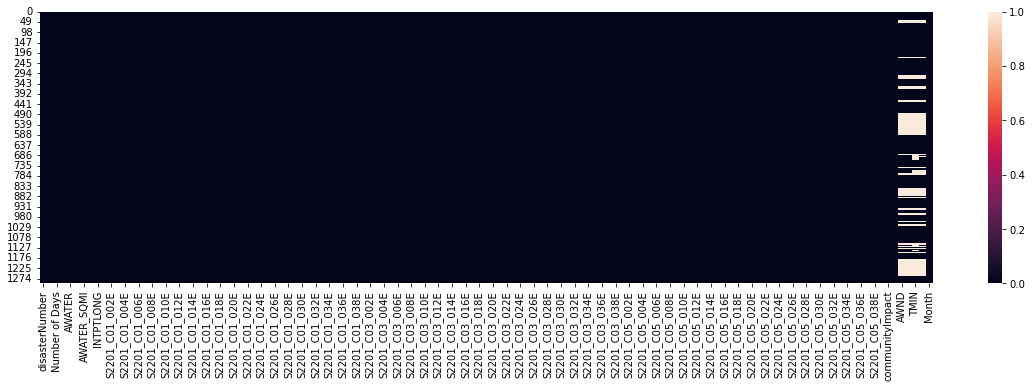

In [108]:
plt.figure(figsize= [20,5])
sns.heatmap(df_impact.isnull()); 

In [109]:
df_impact = pd.get_dummies(df_impact, columns = ['incidentType'#,'timeToDeclaration'
                                                 ,'Month'], drop_first = True)
# df_impact['disasterSize']

In [110]:
from sklearn.impute import SimpleImputer
knnImpute = KNNImputer(n_neighbors = 5)

# df_impact.dropna(axis=0,inplace = True)

X = df_impact.drop(['communityImpact','disasterNumber'], axis = 1)
cols = X.columns

X = knnImpute.fit_transform(X)

y = df_impact['communityImpact']#.values.reshape(-1,1)

X = pd.DataFrame(X, columns = cols)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [111]:
X.describe()

,Number of Days,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG,S2201_C01_001E,S2201_C01_002E,S2201_C01_003E,...,Month_03,Month_04,Month_05,Month_06,Month_07,Month_08,Month_09,Month_10,Month_11,Month_12
count,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,...,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000,1298.000000
mean,2.516660,20.717692,17.132361,5.957316,2.725150,32.107716,-85.087258,9.798779,8.960851,9.212912,...,0.105547,0.090139,0.070878,0.023112,0.019260,0.126348,0.274268,0.123267,0.009245,0.091680
std,1.004346,1.172486,2.288302,1.160537,1.686901,7.622304,11.729098,1.334807,1.281609,1.383522,...,0.307375,0.286491,0.256720,0.150319,0.137492,0.332369,0.446317,0.328870,0.095742,0.288684
min,1.098612,16.342507,6.177944,1.763360,0.000000,17.948052,-164.188912,6.182085,5.484797,5.337538,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.609438,20.562088,15.992651,5.797962,1.482908,29.540176,-92.555263,8.891166,8.104099,8.250163,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.079442,21.095927,17.186511,6.330546,2.504572,32.744255,-86.267021,9.555418,8.726237,8.970813,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.401197,21.403762,18.459174,6.637909,3.716616,37.117219,-79.310750,10.616308,9.677541,10.059014,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,4.736198,25.379355,23.837921,10.612216,9.070872,64.783686,-65.307720,14.288864,13.094015,13.928254,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [112]:
# sns.heatmap(confusion_matrix(y_test,y_pred),cmap = 'coolwarm', annot = True)
# for col in X_train.columns:
#     print(col)

In [113]:
rfc = RFC()
rfc.fit(X_train,y_train)


RandomForestClassifier()

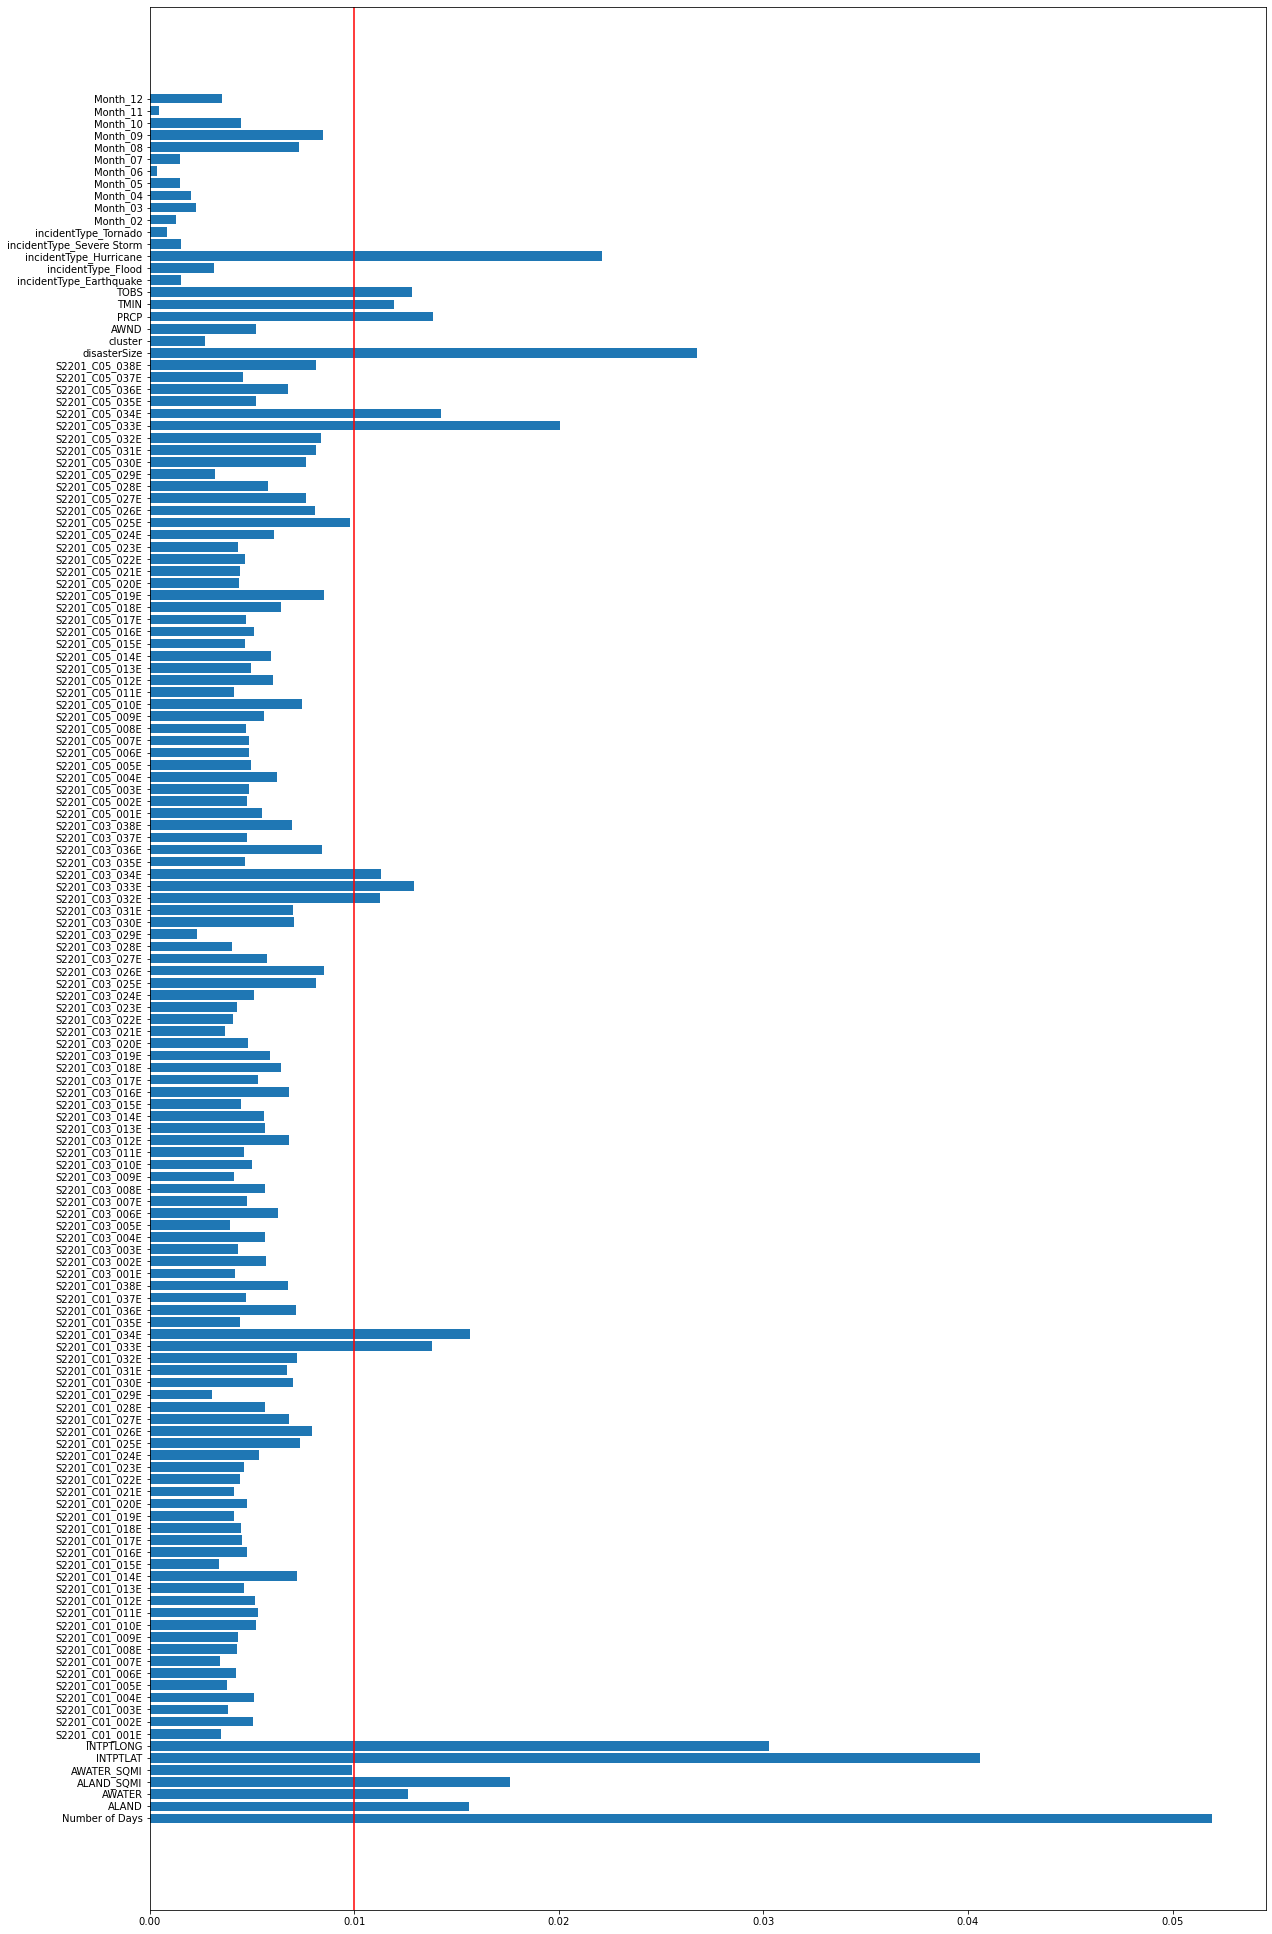

In [114]:
plt.figure(figsize = [20,35])
#Visually inspect the feature importances
names = X_train.columns
plt.barh(names,rfc.feature_importances_)
plt.axvline(x = 0.01,color ='red');



In [115]:
# rfc.feature_importances_
X['disasterSize']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1293    0.0
1294    0.0
1295    0.0
1296    0.0
1297    0.0
Name: disasterSize, Length: 1298, dtype: float64

In [116]:
#C
features = pd.DataFrame(zip(names,rfc.feature_importances_), columns = ['columns','values'])
features = features[features['values']>=0.0075]#0.086
features

,columns,values
0,Number of Days,0.051949
1,ALAND,0.015599
2,AWATER,0.012644
3,ALAND_SQMI,0.017621
4,AWATER_SQMI,0.009895
5,INTPTLAT,0.040581
6,INTPTLONG,0.030266
32,S2201_C01_026E,0.007941
39,S2201_C01_033E,0.013794
40,S2201_C01_034E,0.015671


In [117]:
features = ['ALAND_SQMI'
            ,'AWATER_SQMI'
            #,'S2201_C01_002E'
            ,'S2201_C05_034E'
            ,'S2201_C05_032E'
            ,'Number of Days'
            ,'INTPTLAT'
            ,'INTPTLONG'
            ,'PRCP'
            
            #Incident Begin Month
            #,'Month_02'
            ,'Month_03'
            ,'Month_04','Month_05'
            ,'Month_06','Month_07'
            ,'Month_08','Month_09'
            ,'Month_10','Month_11'
            ,'Month_12'
            #Incident Type
            ,'incidentType_Earthquake'
            ,'incidentType_Flood'
            ,'incidentType_Hurricane'
            ,'incidentType_Severe Storm'
            ,'incidentType_Tornado'
            #Number of days to the incident
            #,'timeToDeclaration_Small'
           
            #This is a proxy for Critical Needs Assistance
            ,'disasterSize'

            
            ##Tested but identified Multi-Collinearity
            #,'TOBS',
            #,'S2201_C03_033E'
            #,Evaluated, but didn't return better results
            #'TMIN'
            #,'S1501_C01_032E'#	0.007081
            #,'S1501_C01_033E'#	0.006841
            #,S1501_C01_035E	0.005459
            #,'S1501_C03_031E'#	0.007481
            #,'S1501_C03_032E'#	0.007800
            #,'S1501_C03_033E'#	0.008455
            #,'S1501_C03_034E	0.005282
            #,'S1501_C05_031E'
            #,'S1603_C03_002E'
            #,'S1603_C03_004E'
        
            #Estimate!!Owner-occupied housing units!!Occupied housing units!!
            #RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!
            #One race --!!Black or African American
            #,'S2502_C03_003E'
           ]

In [118]:
knnImpute = KNNImputer(n_neighbors = 5)
# df_impact = df_impact[df_impact['incidentType_Hurricane']==1]
X = df_impact.drop(['communityImpact','disasterNumber'], axis = 1)
cols = X.columns

X = knnImpute.fit_transform(X)
y = df_impact['communityImpact']#.values.reshape(-1,1)

X = pd.DataFrame(X, columns = cols)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


## Check for Multi-Collinearity

In [119]:
X = X[features]
X.columns = features
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=42)

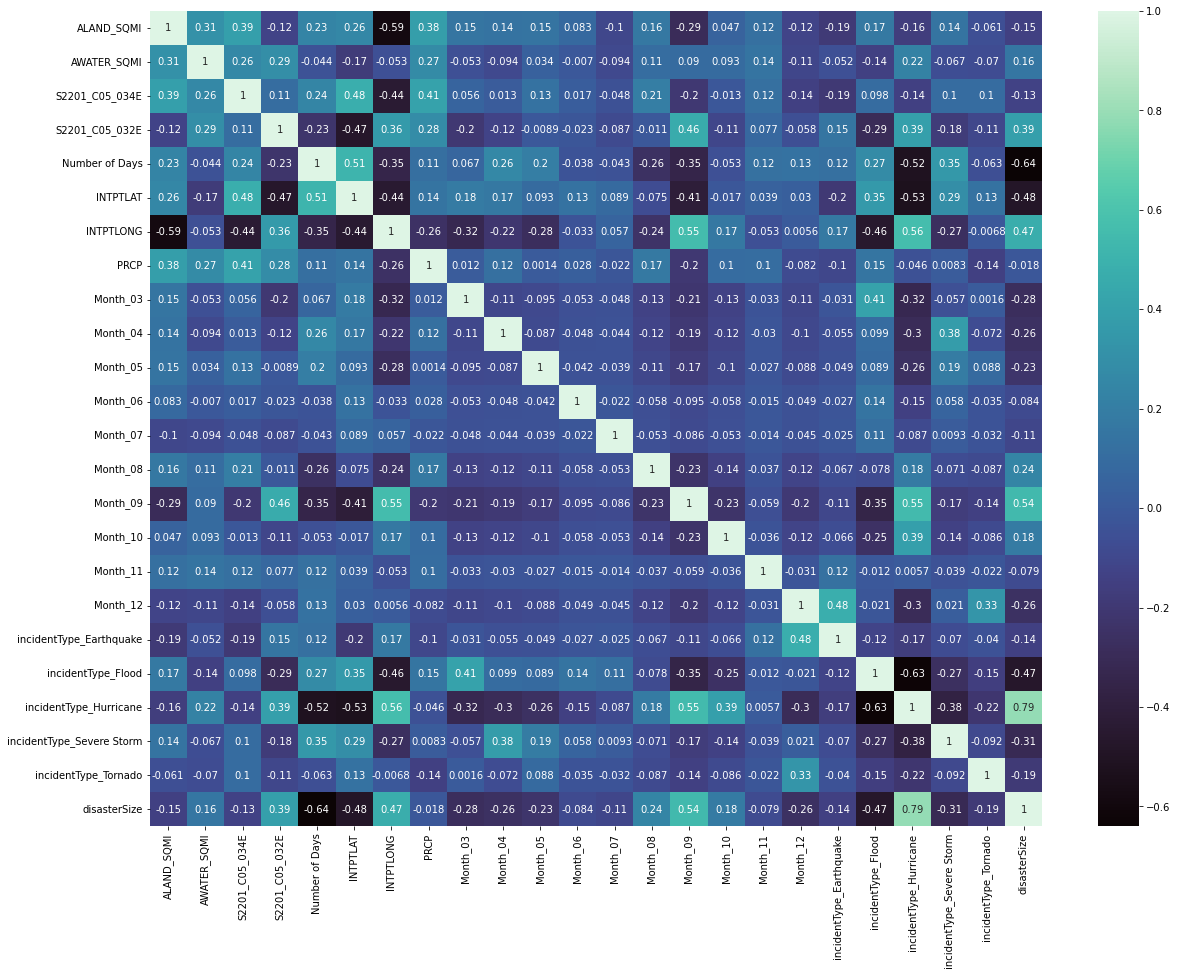

In [120]:
plt.figure(figsize = [20,15])
sns.heatmap(X.corr(method = 'spearman'),cmap='mako', annot = True);

## Begin Modeling for the Community Impact Classification
> Five Fold Cross Validation

In [121]:
#Hyper Parameter Tuning
n_estimators = [10,100,1000]#,10000]
max_features = ['auto','sqrt']
max_depth    = [2,4,6]
min_samples_split = [2,4,6]
min_samples_leaf = [2,4,6]
bootstrap = [True,False]
criterion = ['gini','entropy']


params = {'n_estimators':n_estimators
             ,'max_features':max_features
             ,'max_depth':max_depth
             ,'min_samples_split':min_samples_split
             ,'min_samples_leaf':min_samples_leaf
             ,'bootstrap':bootstrap
             ,'criterion':criterion
         }


In [122]:
# random_rfc = RFC()
# rfc_rcv = RandomizedSearchCV(estimator = random_rfc, param_distributions = params
#                             , verbose = 2,cv = 10, n_jobs = -1)
# # rfc.fit(X_train,y_train)
# # y_pred_rfc = rfc.predict(X_test)

# rfc_rcv.fit(X_train,y_train)
# y_pred_rfc = rfc_rcv.predict(X_test)

# #Best Parameters Random Forest
# param = rfc_rcv.best_params_
# param

## Five Fold Cross Validation

In [123]:

# grid_rfc = RFC()
# rfc_grid = GridSearchCV(estimator = grid_rfc, param_grid = params
#                             , verbose = 2,cv = 5, return_train_score=True)
# rfc_grid.fit(X_train,y_train)
# y_pred_rfc = rfc_grid.predict(X_test)

In [124]:
#5-Fold Cross Validation output

# param = rfc_grid.best_params_
# param
# param = {'bootstrap': False,
#  'criterion': 'entropy',
#  'max_depth': 6,
#  'max_features': 'sqrt',
#  'min_samples_leaf': 4,
#  'min_samples_split': 2,
#  'n_estimators': 10}

# param ={'bootstrap': False,
#  'criterion': 'gini',
#  'max_depth': 6,
#  'max_features': 'sqrt',
#  'min_samples_leaf': 2,
#  'min_samples_split': 2,
#  'n_estimators': 10}

## Optimized Random Forest


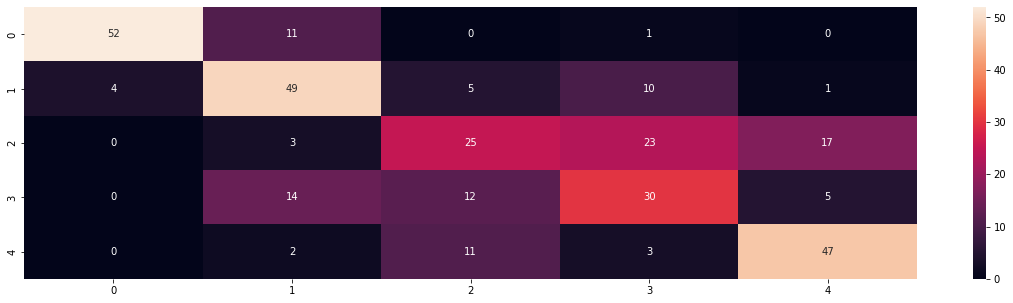

In [125]:
plt.figure(figsize = [20,5])

# rfc = RFC(n_estimators = param['n_estimators']
#          ,min_samples_split = param['min_samples_split']
#          ,min_samples_leaf = param['min_samples_leaf']
#          ,max_features = param['max_features']
#          ,max_depth = param['max_depth']
#          ,bootstrap = param['bootstrap']
#          ,criterion = param['criterion']
#          )

rfc = RFC()
# rfc = make_pipeline(StandardScaler(),rfc)

rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)

#RandomForestClassifier
sns.heatmap(confusion_matrix(y_test,y_pred),cmap = 'rocket', annot = True);

In [126]:
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred,average='macro')
recall = recall_score(y_test,y_pred,average='macro')
f1 = f1_score(y_test,y_pred,average = 'macro')

print('Random Forest')
print('The accuracy score is {:.2}'.format(accuracy))
print('The precision score is {:.2}'.format(precision))
print('The recall score is {:.2}'.format(recall))
print('The f1 score is {:.2}'.format(f1))

Random Forest
The accuracy score is 0.62
The precision score is 0.63
The recall score is 0.63
The f1 score is 0.62


In [127]:
rfc.predict_proba(X_test)

array([[0.  , 0.01, 0.06, 0.05, 0.88],
       [0.  , 0.06, 0.17, 0.07, 0.7 ],
       [0.  , 0.02, 0.49, 0.19, 0.3 ],
       ...,
       [0.02, 0.56, 0.14, 0.27, 0.01],
       [0.02, 0.39, 0.15, 0.43, 0.01],
       [0.41, 0.52, 0.02, 0.05, 0.  ]])

In [128]:
df_ = X_test.copy()
df_['y_test'] = y_test
df_['y_pred'] = y_pred
df_['y_pred_proba'] = list(rfc.predict_proba(X_test))

classes = str(rfc.classes_)
df_['classes'] = classes
df_.head(50)

,ALAND_SQMI,AWATER_SQMI,S2201_C05_034E,S2201_C05_032E,Number of Days,INTPTLAT,INTPTLONG,PRCP,Month_03,Month_04,...,incidentType_Earthquake,incidentType_Flood,incidentType_Hurricane,incidentType_Severe Storm,incidentType_Tornado,disasterSize,y_test,y_pred,y_pred_proba,classes
994,5.154262,1.213428,11.165451,6.016157,4.025352,37.873291,-84.583960,1.781142,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,Very Low,Very Low,"[0.0, 0.01, 0.06, 0.05, 0.88]",['Catastrophic' 'Large' 'Low' 'Medium' 'Very L...
578,6.214250,4.858501,11.015690,10.034165,4.382027,41.472247,-87.374337,2.093329,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,Very Low,Very Low,"[0.0, 0.06, 0.17, 0.07, 0.7]",['Catastrophic' 'Large' 'Low' 'Medium' 'Very L...
1163,6.451762,2.164242,10.795076,5.575949,4.077537,35.158366,-96.602857,1.893346,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,Medium,Low,"[0.0, 0.02, 0.49, 0.19, 0.3]",['Catastrophic' 'Large' 'Low' 'Medium' 'Very L...
722,6.018754,1.937734,10.532603,2.079442,4.110874,33.659670,-88.782468,1.968961,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,Very Low,Medium,"[0.0, 0.19, 0.2, 0.35, 0.26]",['Catastrophic' 'Large' 'Low' 'Medium' 'Very L...
561,3.601059,0.875052,10.316822,8.255828,1.386294,18.130718,-66.472244,1.780909,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,Catastrophic,Catastrophic,"[1.0, 0.0, 0.0, 0.0, 0.0]",['Catastrophic' 'Large' 'Low' 'Medium' 'Very L...
629,5.909642,1.877019,10.845641,7.290975,2.079442,35.700357,-77.921598,1.626156,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,Very Low,Medium,"[0.09, 0.34, 0.1, 0.4, 0.07]",['Catastrophic' 'Large' 'Low' 'Medium' 'Very L...
898,6.210480,2.822033,10.896109,7.242798,2.995732,34.885368,-82.723377,2.111241,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,Very Low,Very Low,"[0.0, 0.03, 0.18, 0.34, 0.45]",['Catastrophic' 'Large' 'Low' 'Medium' 'Very L...
1006,5.945753,1.297463,10.829253,3.637586,4.025352,37.922940,-83.258944,1.732770,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,Low,Very Low,"[0.01, 0.07, 0.14, 0.37, 0.41]",['Catastrophic' 'Large' 'Low' 'Medium' 'Very L...
346,6.446575,1.132047,10.581343,3.218876,3.583519,36.648902,-90.867060,0.000000,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,Medium,Very Low,"[0.0, 0.12, 0.25, 0.22, 0.41]",['Catastrophic' 'Large' 'Low' 'Medium' 'Very L...
1003,6.083034,1.931956,11.001016,6.263398,4.025352,37.725511,-84.278362,1.929384,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,Very Low,Very Low,"[0.0, 0.05, 0.17, 0.05, 0.73]",['Catastrophic' 'Large' 'Low' 'Medium' 'Very L...


In [129]:
for classes in rfc.predict_proba(X_test):
    print(classes)

[0.   0.01 0.06 0.05 0.88]
[0.   0.06 0.17 0.07 0.7 ]
[0.   0.02 0.49 0.19 0.3 ]
[0.   0.19 0.2  0.35 0.26]
[1. 0. 0. 0. 0.]
[0.09 0.34 0.1  0.4  0.07]
[0.   0.03 0.18 0.34 0.45]
[0.01 0.07 0.14 0.37 0.41]
[0.   0.12 0.25 0.22 0.41]
[0.   0.05 0.17 0.05 0.73]
[0.   0.14 0.16 0.31 0.39]
[0.   0.2  0.31 0.42 0.07]
[0.   0.04 0.73 0.05 0.18]
[0.   0.19 0.26 0.45 0.1 ]
[0.   0.01 0.22 0.01 0.76]
[0.   0.03 0.26 0.05 0.66]
[1. 0. 0. 0. 0.]
[0.13 0.37 0.05 0.42 0.03]
[1. 0. 0. 0. 0.]
[0.06 0.75 0.08 0.05 0.06]
[0.   0.01 0.23 0.08 0.68]
[0.01 0.16 0.24 0.49 0.1 ]
[0.01 0.04 0.66 0.15 0.14]
[0.13 0.23 0.07 0.56 0.01]
[0.01 0.03 0.16 0.1  0.7 ]
[0.   0.   0.06 0.01 0.93]
[1. 0. 0. 0. 0.]
[0.97 0.02 0.01 0.   0.  ]
[0.99 0.   0.   0.01 0.  ]
[0.   0.03 0.1  0.02 0.85]
[1. 0. 0. 0. 0.]
[0.39 0.56 0.   0.04 0.01]
[0.01 0.01 0.56 0.1  0.32]
[0.24 0.73 0.01 0.02 0.  ]
[0.   0.25 0.2  0.39 0.16]
[0.98 0.   0.   0.01 0.01]
[0.03 0.36 0.17 0.35 0.09]
[0.1  0.47 0.07 0.34 0.02]
[0.17 0.71 0.02 0.1  0. 

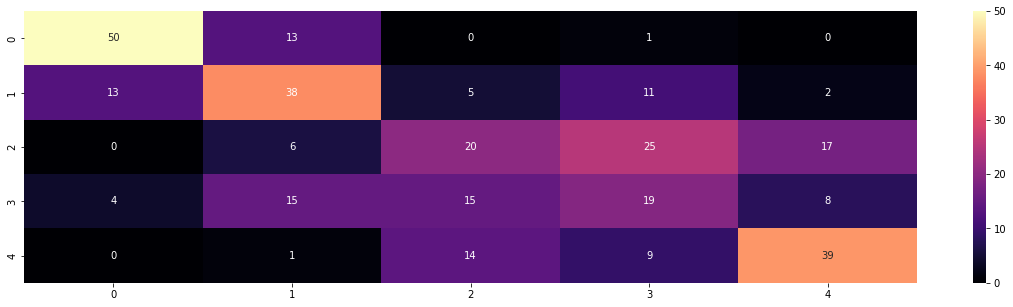

In [130]:


# decTree= DTC(criterion = param['criterion']
#             ,max_depth = param['max_depth']
#             ,min_samples_split =  param['min_samples_split']
#             ,min_samples_leaf = param['min_samples_leaf']
#             ,max_features = param['max_features']
#             )
decTree = DTC()
decTree.fit(X_train,y_train)
y_pred_dec = decTree.predict(X_test)
plt.figure(figsize = [20,5])

#DecisionTreeClassifier
sns.heatmap(confusion_matrix(y_test,y_pred_dec),cmap = 'magma', annot = True);

In [131]:
accuracy = accuracy_score(y_test,y_pred_dec)
precision = precision_score(y_test,y_pred_dec,average='macro')
recall = recall_score(y_test,y_pred_dec,average='macro')
f1 = f1_score(y_test,y_pred_dec,average = 'macro')

print('Decision Tree')
print('The accuracy score is {:.2}'.format(accuracy))
print('The precision score is {:.2}'.format(precision))
print('The recall score is {:.2}'.format(recall))
print('The f1 score is {:.2}'.format(f1))
# print(rfc.decision_path(X_train))

Decision Tree
The accuracy score is 0.51
The precision score is 0.5
The recall score is 0.51
The f1 score is 0.51


In [132]:
# logreg = LogisticRegression()
pipel = make_pipeline(StandardScaler()
                      #multi_class{‘auto’, ‘ovr’, ‘multinomial’}
                     ,LogisticRegression(penalty= 'l1',solver = 'liblinear'
                                        , max_iter = 1000, multi_class = 'ovr'
                                        )
                     )
pipel.fit(X_train,y_train)
y_predl = pipel.predict(X_test)


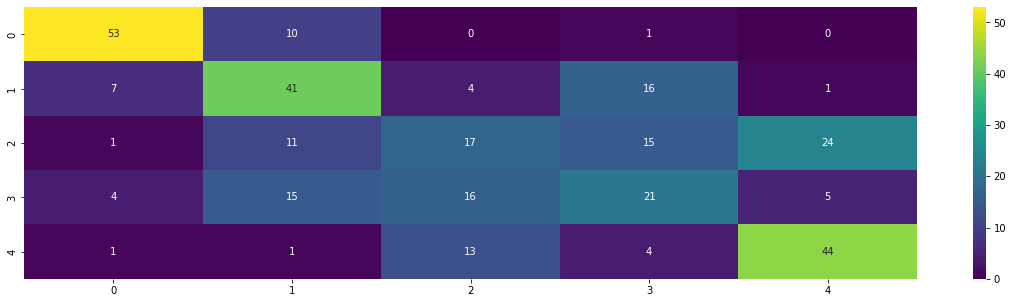

In [133]:
plt.figure(figsize = [20,5])
#Logistic Regression
sns.heatmap(confusion_matrix(y_test,y_predl),cmap = 'viridis', annot = True);

In [134]:
accuracy = accuracy_score(y_test,y_predl)
precision = precision_score(y_test,y_predl,average='macro')
recall = recall_score(y_test,y_predl,average='macro')
f1 = f1_score(y_test,y_predl,average = 'macro')

print('Logistic Regression')
print('The accuracy score is {:.2}'.format(accuracy))
print('The precision score is {:.2}'.format(precision))
print('The recall score is {:.2}'.format(recall))
print('The f1 score is {:.2}'.format(f1))

Logistic Regression
The accuracy score is 0.54
The precision score is 0.53
The recall score is 0.54
The f1 score is 0.53


In [135]:
knn= KNN(n_neighbors = 5, weights = 'distance')
# pipe = make_pipeline(StandardScaler(),knn)
knn.fit(X_train,y_train)
knn_pred = knn.predict(X_test)



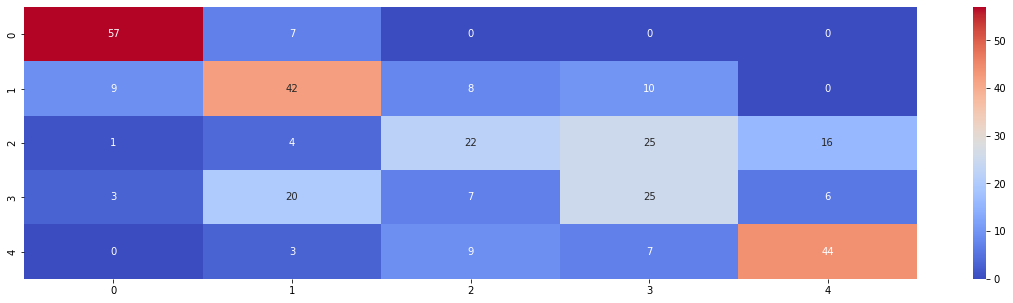

In [136]:
plt.figure(figsize = [20,5])
sns.heatmap(confusion_matrix(y_test,knn_pred),cmap = 'coolwarm', annot = True);

In [137]:
accuracy = accuracy_score(y_test,knn_pred)
precision = precision_score(y_test,knn_pred,average='macro')
recall = recall_score(y_test,knn_pred,average='macro')
f1 = f1_score(y_test,knn_pred,average = 'macro')

print('KNN')
print('The accuracy score is {:.2}'.format(accuracy))
print('The precision score is {:.2}'.format(precision))
print('The recall score is {:.2}'.format(recall))
print('The f1 score is {:.2}'.format(f1))

KNN
The accuracy score is 0.58
The precision score is 0.58
The recall score is 0.59
The f1 score is 0.58


## Voting Classifier Hard Voting

In [138]:
from sklearn.ensemble import VotingClassifier

In [139]:
clf = VotingClassifier(estimators = [('RandomForest',rfc),('KNN',knn)],voting='hard')
clf.fit(X_train,y_train)
voting_pred = clf.predict(X_test)


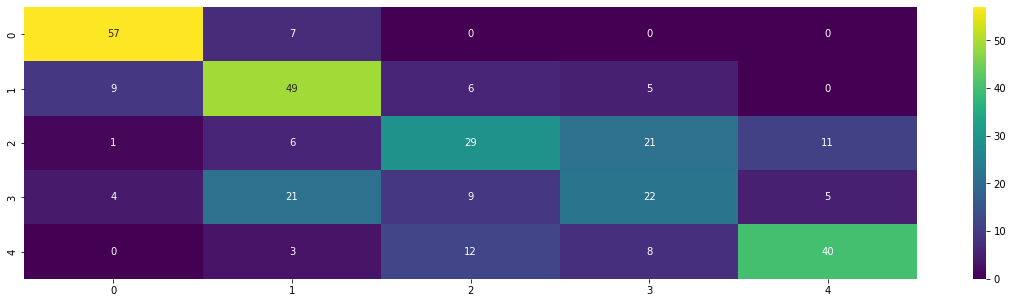

In [140]:
plt.figure(figsize = [20,5])
sns.heatmap(confusion_matrix(y_test,voting_pred),cmap = 'viridis', annot = True);

In [141]:
accuracy = accuracy_score(y_test,voting_pred)
precision = precision_score(y_test,voting_pred,average='macro')
recall = recall_score(y_test,voting_pred,average='macro')
f1 = f1_score(y_test,voting_pred,average = 'macro')

print('VotingClassifier')
print('The accuracy score is {:.2}'.format(accuracy))
print('The precision score is {:.2}'.format(precision))
print('The recall score is {:.2}'.format(recall))
print('The f1 score is {:.2}'.format(f1))

VotingClassifier
The accuracy score is 0.61
The precision score is 0.6
The recall score is 0.6
The f1 score is 0.6


## Voting Classifier Soft Voting

In [142]:
# from sklearn.ensemble import VotingClassifier

In [143]:
clf_s = VotingClassifier(estimators = [('RandomForest',rfc),('KNN',knn)],voting='soft')
clf_s.fit(X_train,y_train)
voting_pred_s = clf.predict(X_test)


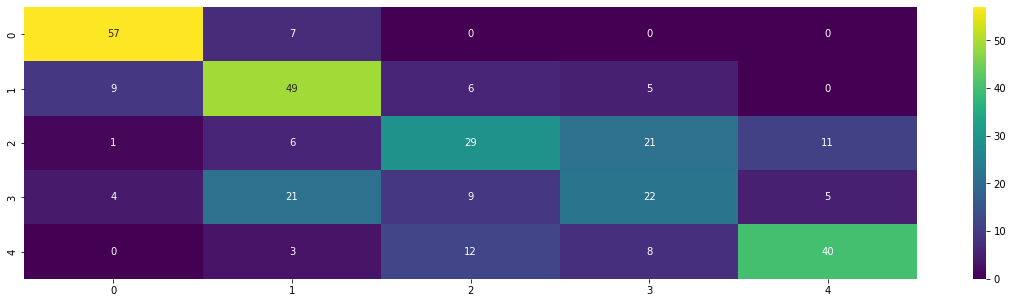

In [144]:
plt.figure(figsize = [20,5])
sns.heatmap(confusion_matrix(y_test,voting_pred_s),cmap = 'viridis', annot = True);

In [145]:
accuracy = accuracy_score(y_test,voting_pred_s)
precision = precision_score(y_test,voting_pred_s,average='macro')
recall = recall_score(y_test,voting_pred_s,average='macro')
f1 = f1_score(y_test,voting_pred_s,average = 'macro')

print('VotingClassifier')
print('The accuracy score is {:.2}'.format(accuracy))
print('The precision score is {:.2}'.format(precision))
print('The recall score is {:.2}'.format(recall))
print('The f1 score is {:.2}'.format(f1))

VotingClassifier
The accuracy score is 0.61
The precision score is 0.6
The recall score is 0.6
The f1 score is 0.6


In [146]:
# X_ =X_test
# X_['y_pred'] = y_pred
# X_['y_test'] = y_test
# X_